In [27]:
# =====================[ Imports ]=====================
import os
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # instead of: from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import timm
import torch
import torch.nn as nn
import gc
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from transformers import AutoTokenizer, AutoModel, BertTokenizer

In [28]:
# =====================[ Configuration ]=====================
# Set base paths for dataset
DATA_DIR = Path("fashion_dataset")
IMAGE_DIR = DATA_DIR / "images"
CSV_PATH = DATA_DIR / "styles.csv"

# Define the target label columns for multi-task learning
label_cols = ['gender', 'masterCategory', 'subCategory', 'baseColour', 'season', 'articleType']

# Load the dataset CSV file and skip any problematic lines
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')

# For experimentation purposes, only use the first 3000 rows


# =====================[ Helper Function: Filter Rare Classes ]=====================
def remove_rows_with_low_value_counts(df, threshold=20, columns=None):
    """
    Remove rows that contain infrequent classes (below a certain threshold) 
    in specified categorical columns.

    Args:
        df (pd.DataFrame): Input DataFrame.
        threshold (int): Minimum number of samples required for a class to be kept.
        columns (list): List of column names to check.

    Returns:
        pd.DataFrame: Filtered DataFrame with rare classes removed.
    """
    if columns is None:
        columns = df.columns  # By default, apply to all columns (not recommended)

    initial_size = df.shape[0]  # Store the original number of rows

    # Boolean mask to keep valid rows
    mask = pd.Series(True, index=df.index)

    for col in columns:
        value_counts = df[col].value_counts()
        valid_values = value_counts[value_counts >= threshold].index
        print(f"Column '{col}': keeping {len(valid_values)} out of {len(value_counts)} classes")
        mask &= df[col].isin(valid_values)

    # Apply mask to filter the DataFrame
    df_filtered = df[mask]

    print(f"Size before filtering: {initial_size}")
    print(f"Size after filtering: {df_filtered.shape[0]}")

    return df_filtered


# Specify the columns to apply the filtering
columns_to_check = ['masterCategory', 'articleType', 'baseColour']

# Apply filtering to remove rare classes
df = remove_rows_with_low_value_counts(df, threshold=20, columns=columns_to_check)

Column 'masterCategory': keeping 6 out of 7 classes
Column 'articleType': keeping 90 out of 143 classes
Column 'baseColour': keeping 42 out of 46 classes
Size before filtering: 44424
Size after filtering: 43972


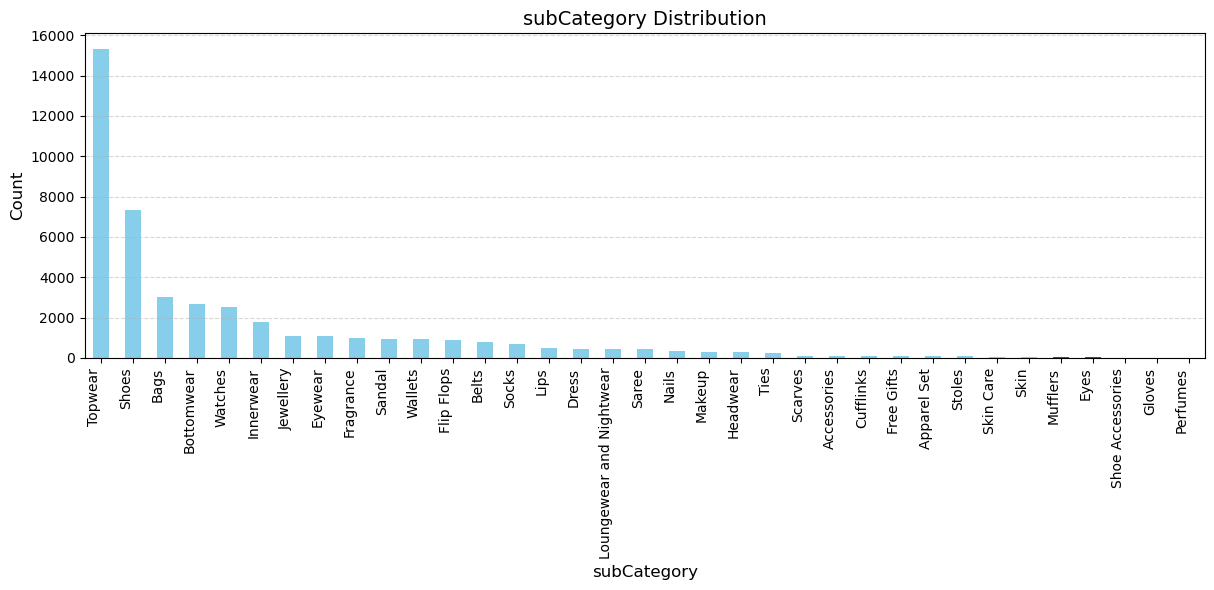

In [29]:
# =====================[ Helper Function: Plot Label Distribution ]=====================
def plot_label_distribution_adaptive(df, column, min_count=20):
    """
    Plot a bar chart showing the distribution of categories within a column.
    Bars with low sample counts are highlighted in red for clarity.

    Args:
        df (pd.DataFrame): Input DataFrame.
        column (str): The column to visualize.
        min_count (int): Threshold for highlighting low-frequency labels.
    """
    counts = df[column].value_counts().sort_values(ascending=False)
    n_labels = len(counts)

    # Automatically adjust figure width based on number of classes
    plt.figure(figsize=(max(12, n_labels * 0.35), 6))

    # Color bars red if count is below min_count
    colors = ['red' if v < min_count else 'skyblue' for v in counts]
    counts.plot(kind="bar", color=colors)

    # Chart aesthetics
    plt.title(f"{column} Distribution", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=90, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Plot label distribution for the subCategory column
plot_label_distribution_adaptive(df, "subCategory", min_count=50)

In [30]:
# =====================[ Function: Load and Preprocess Dataset ]=====================
def load_fashion_data(df):
    """
    Load and preprocess the fashion product dataset.

    Steps:
    - Drop rows with missing values in important label columns.
    - Create image filenames based on the 'id' column.
    - Keep only rows with images that exist in the image directory.
    - Combine label columns into a single 'labels' string (useful for captioning or multi-tasking).

    Args:
        df (pd.DataFrame): Raw DataFrame loaded from CSV.

    Returns:
        pd.DataFrame: Cleaned and filtered DataFrame.
    """
    # Drop samples missing any of the main label fields
    df = df.dropna(subset=['gender', 'masterCategory', 'subCategory', 'baseColour', 'season','articleType'])

    # Create a new column 'image' from the 'id' field
    df['image'] = df['id'].astype(str) + ".jpg"

    # Keep only rows where image files actually exist
    df = df[df['image'].isin(os.listdir(IMAGE_DIR))]

    # Concatenate label columns into a single string (e.g., for text-based tasks or debugging)
    df['labels'] = df[['gender', 'masterCategory', 'subCategory', 'baseColour', 'season','articleType']].agg('|'.join, axis=1)

    print(f" Dataset loaded: {len(df)} valid image records")
    return df


# =====================[ Function: Analyze Subcategory Distribution ]=====================
def analyze_subcategory(df):
    """
    Analyze the distribution of 'subCategory' values in the dataset.
    Also provides recommendations for threshold-based filtering.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.Series: Value counts of subcategories.
    """
    subcategory_counts = df['subCategory'].value_counts()

    print("\n === SUBCATEGORY ANALYSIS ===")
    print(f"Total unique subcategories: {len(subcategory_counts)}")
    print(f"Most common subcategory: '{subcategory_counts.index[0]}' ({subcategory_counts.iloc[0]} samples)")
    print(f"Least common subcategory: '{subcategory_counts.index[-1]}' ({subcategory_counts.iloc[-1]} samples)")

    print("\n Filtering Recommendations:")
    for threshold in [30, 50, 100, 200]:
        classes_to_remove = subcategory_counts[subcategory_counts < threshold]
        samples_retained = len(df) - classes_to_remove.sum()
        retention_pct = (samples_retained / len(df)) * 100
        print(f"  - Threshold {threshold}: Remove {len(classes_to_remove)} classes "
              f"→ Retain {retention_pct:.1f}% of data")

    return subcategory_counts


# =====================[ Function: Filter Dataset Based on Threshold ]=====================
def filter_data(df, subcategory_threshold=50):
    """
    Filter out subcategories that appear less than a specified threshold.

    Args:
        df (pd.DataFrame): Input DataFrame.
        subcategory_threshold (int): Minimum number of samples required for a subcategory to be kept.

    Returns:
        pd.DataFrame: Filtered dataset with rare subcategories removed.
    """
    subcategory_counts = df['subCategory'].value_counts()
    valid_subcategories = subcategory_counts[subcategory_counts >= subcategory_threshold].index

    df_filtered = df[df['subCategory'].isin(valid_subcategories)]

    print(f"""
📂 SubCategory Filtering Summary
----------------------------------
- Threshold: {subcategory_threshold}
- Original subcategories: {len(df['subCategory'].unique())}
- Subcategories kept: {len(df_filtered['subCategory'].unique())}
- Filtered dataset size: {len(df_filtered)} samples
- Retention rate: {len(df_filtered) / len(df) * 100:.1f}%
""")

    return df_filtered


# =====================[ Step-by-step Execution ]=====================

# Step 1: Load and clean dataset
df = load_fashion_data(df)

# Step 2: Analyze subcategory distribution
subcategory_counts = analyze_subcategory(df)

# Step 3: Filter dataset based on subcategory threshold
df = filter_data(df, subcategory_threshold=50)

# ➕ Now you can continue using `df` for modeling or visualization

C:\Users\Hamid\AppData\Local\Temp\ipykernel_23912\1875146605.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['id'].astype(str) + ".jpg"


 Dataset loaded: 43947 valid image records

 === SUBCATEGORY ANALYSIS ===
Total unique subcategories: 35
Most common subcategory: 'Topwear' (15324 samples)
Least common subcategory: 'Perfumes' (6 samples)

 Filtering Recommendations:
  - Threshold 30: Remove 3 classes → Retain 99.9% of data
  - Threshold 50: Remove 5 classes → Retain 99.7% of data
  - Threshold 100: Remove 9 classes → Retain 99.1% of data
  - Threshold 200: Remove 13 classes → Retain 98.1% of data

📂 SubCategory Filtering Summary
----------------------------------
- Threshold: 50
- Original subcategories: 35
- Subcategories kept: 30
- Filtered dataset size: 43830 samples
- Retention rate: 99.7%



In [31]:
# =====================[ Step 1: Drop Rare Colour Classes ]=====================
# Calculate the frequency of each unique baseColour
counts = df['baseColour'].value_counts()

# Keep only those colours with at least 40 samples
valid_colours = counts[counts >= 40].index

# Filter the DataFrame to only include those valid colours
df = df[df['baseColour'].isin(valid_colours)].reset_index(drop=True)


# =====================[ Step 2: Define Color Simplification Map ]=====================
# This dictionary maps similar or redundant colors to a unified label
# Useful to reduce label noise and imbalance in classification tasks
color_mapping = {
    # Grays & neutrals
    'Beige': 'Beige',
    'Black': 'Black',
    'Charcoal': 'Gray',
    'Cream': 'Cream',
    'Grey': 'Gray',
    'Grey Melange': 'Gray',
    'Steel': 'Gray',
    'Off White': 'White',
    'White': 'White',
    'Nude': 'Skin',
    'Tan': 'Beige',
    'Taupe': 'Taupe',
    
    # Browns
    'Brown': 'Brown',
    'Mushroom Brown': 'Brown',
    'Coffee Brown': 'Brown',
    'Copper': 'Brown',
    
    # Metallics
    'Silver': 'Metallic',
    'Gold': 'Metallic',
    'Bronze': 'Metallic',
    'Metallic': 'Metallic',

    # Reds
    'Red': 'Red',
    'Burgundy': 'Red',
    'Maroon': 'Red',

    # Pinks & Purples
    'Pink': 'Pink',
    'Rose': 'Pink',
    'Magenta': 'Pink',
    'Mauve': 'Purple',
    'Lavender': 'Purple',
    'Purple': 'Purple',

    # Oranges & Yellows
    'Rust': 'Orange',
    'Orange': 'Orange',
    'Peach': 'Peach',
    'Mustard': 'Yellow',
    'Yellow': 'Yellow',

    # Greens
    'Green': 'Green',
    'Olive': 'Green',
    'Sea Green': 'Green',
    'Fluorescent Green': 'Green',
    'Lime Green': 'Green',
    'Khaki': 'Khaki',  # Often used as its own color class

    # Blues
    'Blue': 'Blue',
    'Navy Blue': 'Blue',

    # Blue-Greens
    'Teal': 'Teal',
    'Turquoise Blue': 'Teal',

    # Ambiguous / mixed
    'Multi': 'Multi',
    'Skin': 'Skin'  # This may need manual review depending on context
}


# =====================[ Step 3: Apply Simplification ]=====================
def simplify_colors(df, color_column='baseColour'):
    """
    Simplify color labels in the dataset using a predefined mapping.

    Args:
        df (pd.DataFrame): Input DataFrame
        color_column (str): Name of the color column to simplify

    Returns:
        pd.DataFrame: DataFrame with simplified color values
    """
    # Make a copy to avoid modifying original data in-place
    df_simplified = df.copy()

    # Apply color mapping (original -> simplified)
    df_simplified[color_column] = df_simplified[color_column].map(color_mapping)

    # For colors not in the mapping, preserve original
    df_simplified[color_column] = df_simplified[color_column].fillna(df[color_column])

    return df_simplified


# Apply the color simplification to the dataframe
df = simplify_colors(df, 'baseColour')


# =====================[ Step 4: Debug Output ]=====================
# Optional: visualize the changes in color labels
print("Color Mapping Applied:")
print("Original → Simplified")
print("-" * 30)
for original, simplified in color_mapping.items():
    if original != simplified:
        print(f"{original:<20} → {simplified}")

# Show unique simplified labels
simplified_labels = sorted(set(color_mapping.values()))
print(f"\n Unique simplified colors ({len(simplified_labels)} total):")
print(simplified_labels)


Color Mapping Applied:
Original → Simplified
------------------------------
Charcoal             → Gray
Grey                 → Gray
Grey Melange         → Gray
Steel                → Gray
Off White            → White
Nude                 → Skin
Tan                  → Beige
Mushroom Brown       → Brown
Coffee Brown         → Brown
Copper               → Brown
Silver               → Metallic
Gold                 → Metallic
Bronze               → Metallic
Burgundy             → Red
Maroon               → Red
Rose                 → Pink
Magenta              → Pink
Mauve                → Purple
Lavender             → Purple
Rust                 → Orange
Mustard              → Yellow
Olive                → Green
Sea Green            → Green
Fluorescent Green    → Green
Lime Green           → Green
Navy Blue            → Blue
Turquoise Blue       → Teal

 Unique simplified colors (20 total):
['Beige', 'Black', 'Blue', 'Brown', 'Cream', 'Gray', 'Green', 'Khaki', 'Metallic', 'Multi', 'Orange', 

In [32]:
# =====================[ Step 5: Encode Labels ]=====================
from sklearn.preprocessing import LabelEncoder

# Dictionary to store fitted LabelEncoders for each label column
label_encoders = {}

# Loop over all label columns and encode them as integers
for col in label_cols:
    le = LabelEncoder()
    
    # Fit encoder on the column and store the transformed values in a new column
    df[col + '_label'] = le.fit_transform(df[col])
    
    # Store the encoder for future inverse-transforming or decoding
    label_encoders[col] = le


# =====================[ Step 6: Split Dataset (Train/Val/Test) ]=====================
from sklearn.model_selection import train_test_split

# Split the full dataset into 90% train/val and 10% test
trainval_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df['subCategory'],  # Maintain subCategory distribution
    random_state=42
)

# Further split the 90% into 80% train and 20% val (which is 72% train, 18% val of total)
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.20,
    stratify=trainval_df['subCategory'],  # Keep stratified distribution again
    random_state=42
)


# =====================[ Step 7: Inspect Final Class Distribution ]=====================
# View the number of samples for each baseColour after all processing steps
print("Final baseColour distribution:")
print(df['baseColour'].value_counts())



Final baseColour distribution:
baseColour
Black       9607
Blue        6631
White       5670
Brown       3535
Gray        3406
Red         3034
Green       2486
Pink        1955
Metallic    1846
Purple      1782
Beige        854
Yellow       854
Orange       586
Multi        389
Cream        378
Peach        194
Teal         187
Skin         167
Khaki        139
Name: count, dtype: int64


In [33]:
# =====================[ Step 8: Define Custom Dataset Class ]=====================
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

class FashionMultiTaskDataset(Dataset):
    """
    Custom PyTorch Dataset for multi-task classification of fashion images.

    Each sample includes:
        - An image loaded from disk
        - A dictionary of label tensors for each classification task
    """

    def __init__(self, df, image_dir, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing image paths and encoded labels.
            image_dir (str or Path): Directory containing image files.
            transform (callable, optional): Transformations to apply to each image.
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        """Return the total number of samples"""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieve a sample consisting of:
            - Preprocessed image
            - Dictionary of label tensors
        """
        row = self.df.loc[idx]

        # Construct the full image path
        img_path = os.path.join(self.image_dir, row['image'])

        # Load image and convert to RGB format
        image = Image.open(img_path).convert('RGB')

        # Apply transformations (resize, normalize, etc.)
        if self.transform:
            image = self.transform(image)

        # Extract all multi-task labels as a dictionary
        labels = {
            'gender': torch.tensor(row['gender_label'], dtype=torch.long),
            'masterCategory': torch.tensor(row['masterCategory_label'], dtype=torch.long),
            'subCategory': torch.tensor(row['subCategory_label'], dtype=torch.long),
            'baseColour': torch.tensor(row['baseColour_label'], dtype=torch.long),
            'season': torch.tensor(row['season_label'], dtype=torch.long),
            'articleType': torch.tensor(row['articleType_label'], dtype=torch.long),
        }

        return image, labels


In [34]:
# =====================[ Step 9: Define Image Transformations ]=====================
from torchvision import transforms

# Common image preprocessing: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(           # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [35]:
# =====================[ Step 10: Create Dataset Objects ]=====================
# Create dataset instances for train, validation, and test splits
train_dataset = FashionMultiTaskDataset(train_df, 'fashion_dataset/images', transform)
val_dataset   = FashionMultiTaskDataset(val_df, 'fashion_dataset/images', transform)
test_dataset  = FashionMultiTaskDataset(test_df, 'fashion_dataset/images', transform)


In [36]:
# =====================[ Step 11: Create DataLoaders ]=====================
# Create DataLoaders to feed data to the model during training/evaluation

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,       # Shuffle for training
    pin_memory=True     # Speed up transfer to GPU
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    pin_memory=True
)

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm
import gc

class FashionMultiTaskModel(nn.Module):
    """
    Multi-task image classification model with support for multiple backbones.
    Dynamically loads pretrained CNNs or ViT, replaces classification head(s),
    and adds six task-specific output heads.
    """

    def __init__(self, num_classes_dict, model_name='resnet50', freeze_layers_except_last_n=2):
        super().__init__()
        self.model_name = model_name

        # ========= Load Backbone ========= #
        if model_name == 'resnet50':
            self.base_model = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(self.base_model.children())[:-1])
            in_features = self.base_model.fc.in_features

        elif model_name == 'efficientnet_b5':
            # Use timm instead of torchvision to avoid hash issues
            self.base_model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=0)
            self.backbone = self.base_model
            in_features = self.base_model.num_features

        elif model_name == 'mobilenet_v2':
            self.base_model = models.mobilenet_v2(pretrained=True)
            self.backbone = self.base_model.features
            in_features = self.base_model.classifier[1].in_features

        elif model_name == 'vit_b_16':
            self.base_model = models.vit_b_16(pretrained=True)
            in_features = self.base_model.heads.head.in_features

        elif model_name == 'convnext_tiny':
            self._load_convnext_memory_aware()
            in_features = self._infer_convnext_feature_size()

        else:
            raise ValueError(f"Model {model_name} not supported")

        torch.cuda.empty_cache()

        # ========= Fine-Tuning Strategy ========= #
        self._freeze_all_layers()
        self._unfreeze_last_n_layers(freeze_layers_except_last_n)

        # Optional pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1) if model_name in ['mobilenet_v2'] else None

        # ========= Output Heads ========= #
        self.gender_head       = nn.Linear(in_features, num_classes_dict['gender'])
        self.master_head       = nn.Linear(in_features, num_classes_dict['masterCategory'])
        self.subcat_head       = nn.Linear(in_features, num_classes_dict['subCategory'])
        self.colour_head       = nn.Linear(in_features, num_classes_dict['baseColour'])
        self.season_head       = nn.Linear(in_features, num_classes_dict['season'])
        self.articleType_head  = nn.Linear(in_features, num_classes_dict['articleType'])

        torch.cuda.empty_cache()
        self.print_trainable_params()

    def _load_convnext_memory_aware(self):
        """Handle memory-optimized loading of ConvNeXt (TIMM + fallback)"""
        try:
            torch.cuda.empty_cache()
            gc.collect()
            self.base_model = timm.create_model('convnext_tiny', pretrained=True, num_classes=0, global_pool='')
            self.backbone = nn.Sequential(
                self.base_model,
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten()
            )
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("TIMM ConvNeXt too memory intensive, falling back to torchvision...")
                torch.cuda.empty_cache()
                gc.collect()
                self.base_model = models.convnext_tiny(pretrained=True)
                self.backbone = self.base_model.features
            else:
                raise e

    def _infer_convnext_feature_size(self):
        """Infer output feature size using a dummy forward pass"""
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).cuda() if torch.cuda.is_available() else torch.randn(1, 3, 224, 224)
            model = self.base_model.cuda() if torch.cuda.is_available() else self.base_model
            out = model(dummy_input)
            return out[-1].shape[1] if isinstance(out, (list, tuple)) else out.shape[1]

    def _freeze_all_layers(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def _unfreeze_last_n_layers(self, n):
        if self.model_name == 'resnet50':
            for layer in list(self.backbone.children())[-n:]:
                for param in layer.parameters():
                    param.requires_grad = True
        elif self.model_name == 'vit_b_16':
            for layer in list(self.base_model.encoder.layers)[-n:]:
                for param in layer.parameters():
                    param.requires_grad = True
            for param in self.base_model.encoder.ln.parameters():
                param.requires_grad = True
        elif self.model_name == 'convnext_tiny':
            if hasattr(self.base_model, 'stages'):
                for stage in list(self.base_model.stages)[-n:]:
                    for param in stage.parameters():
                        param.requires_grad = True
                if hasattr(self.base_model, 'norm'):
                    for param in self.base_model.norm.parameters():
                        param.requires_grad = True
        else:
            for layer in list(self.base_model.modules())[-n * 5:]:
                for param in layer.parameters():
                    param.requires_grad = True

    def forward(self, x):
        if self.model_name == 'vit_b_16':
            n, c, h, w = x.shape
            p = self.base_model.patch_size
            x = self.base_model.conv_proj(x).reshape(n, self.base_model.hidden_dim, -1).permute(0, 2, 1)
            x = torch.cat([self.base_model.class_token.expand(n, -1, -1), x], dim=1)
            x = self.base_model.encoder.dropout(x + self.base_model.encoder.pos_embedding)
            x = self.base_model.encoder.ln(self.base_model.encoder.layers(x))
            features = x[:, 0]
        else:
            features = self.backbone(x)
            if features.dim() > 2:
                features = features.view(features.size(0), -1)
            elif self.global_pool:
                features = self.global_pool(features).view(features.size(0), -1)

        return {
            'gender': self.gender_head(features),
            'masterCategory': self.master_head(features),
            'subCategory': self.subcat_head(features),
            'baseColour': self.colour_head(features),
            'season': self.season_head(features),
            'articleType': self.articleType_head(features),
        }

    def print_trainable_params(self):
        """Prints model parameter stats and GPU memory info"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Model: {self.model_name}")
        print(f"Total params: {total:,} | Trainable: {trainable:,} ({100*trainable/total:.2f}%)")
        if torch.cuda.is_available():
            print(f"GPU Mem (allocated): {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU Mem (reserved) : {torch.cuda.memory_reserved() / 1e9:.2f} GB")

In [38]:
def optimize_memory_settings():
    """
    Configure PyTorch and CUDA for better memory handling.
    Useful on systems with limited GPU memory.
    """
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    if hasattr(torch.backends.cuda, 'enable_flash_sdp'):
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_mem_efficient_sdp(True)

def clear_gpu_memory():
    """Release unused GPU memory and call garbage collector"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

In [39]:
def train_step_with_memory_management(model, data_loader, optimizer, criterion, device):
    """
    Perform one epoch of training using memory-efficient techniques:
    - Mixed precision training
    - Zeroing gradients with `set_to_none=True`
    - Periodic GPU memory cleanup
    """
    model.train()
    total_loss = 0

    for batch_idx, (data, targets) in enumerate(data_loader):
        data = data.to(device, non_blocking=True)
        for key in targets:
            targets[key] = targets[key].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            outputs = model(data)
            loss = sum(criterion[key](outputs[key], targets[key]) for key in outputs)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Clear GPU memory every 10 batches to prevent accumulation
        if batch_idx % 10 == 0:
            clear_gpu_memory()

    return total_loss / len(data_loader)


In [40]:
# =====================[ Step 12: Model Setup and Loss Functions ]=====================

# Define the number of output classes for each task
# This dictionary will be used to configure the output layers
num_classes_dict = {
    col: df[col + "_label"].nunique()  # Alternatively: df[col + "_label"].max() + 1
    for col in label_cols
}

# Select the appropriate device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a CrossEntropyLoss function for each classification task
# Stored in a dictionary keyed by label column name
criterions = {
    col: nn.CrossEntropyLoss()
    for col in label_cols
}

Using device: cuda


In [41]:
def train_and_evaluate_model(model_name, num_classes_dict, train_loader, val_loader, test_loader,
                             device, criterions, label_cols, epochs=4, learning_rate=0.001):
    """
    Trains a FashionMultiTaskModel using the specified architecture and evaluates it.

    Args:
        model_name (str): Name of the base model architecture (e.g., 'resnet50', 'convnext_tiny').
        num_classes_dict (dict): Dictionary mapping each task to its number of classes.
        train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
        device (torch.device): 'cuda' or 'cpu'.
        criterions (dict): Dictionary mapping each task to its loss function.
        label_cols (list): List of task names (keys used in model output and label dicts).
        epochs (int): Number of training epochs.
        learning_rate (float): Base learning rate.

    Returns:
        dict: Training history and final test metrics.
    """
    print("\n" + "=" * 50)
    print(f"Training model: {model_name.upper()}")
    print("=" * 50)

    # Initialize model and move to selected device
    model = FashionMultiTaskModel(num_classes_dict, model_name)
    model = model.to(device)

    # Separate parameters for backbone and heads to use different learning rates
    backbone_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'backbone' in name or 'base_model' in name:
            backbone_params.append(param)
        else:
            head_params.append(param)

    # Define optimizer with differential learning rates
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': learning_rate * 0.1, 'weight_decay': 1e-4},  # Lower LR for pretrained
        {'params': head_params, 'lr': learning_rate * 2, 'weight_decay': 1e-4}         # Higher LR for new heads
    ])

    # Learning rate scheduler for smooth decay
    from torch.optim.lr_scheduler import OneCycleLR
    scheduler = OneCycleLR(
        optimizer, 
        max_lr=learning_rate * 2, 
        steps_per_epoch=len(train_loader), 
        epochs=epochs
    )

    # ===================[ Training Step ]===================
    def train_epoch(model, loader):
        model.train()
        total_loss = 0
        all_true = {col: [] for col in label_cols}
        all_pred = {col: [] for col in label_cols}

        for imgs, labels in tqdm(loader,disable=True):
            imgs = imgs.to(device)
            labels = {col: labels[col].to(device) for col in label_cols}

            outputs = model(imgs)
            loss = sum(criterions[col](outputs[col], labels[col]) for col in label_cols)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            total_loss += loss.item()

            # Store predictions for metrics
            for col in label_cols:
                preds = outputs[col].argmax(dim=1).cpu().numpy()
                all_pred[col].extend(preds)
                all_true[col].extend(labels[col].cpu().numpy())

        # Calculate metrics for each task
        train_metrics = {
            col: {
                "accuracy": accuracy_score(all_true[col], all_pred[col]),
                "f1_macro": f1_score(all_true[col], all_pred[col], average='macro', zero_division=0)
            } for col in label_cols
        }

        return total_loss / len(loader), train_metrics

    # ===================[ Evaluation Step ]===================
    def evaluate(model, loader):
        model.eval()
        total_loss = 0
        all_true = {col: [] for col in label_cols}
        all_pred = {col: [] for col in label_cols}

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = {col: labels[col].to(device) for col in label_cols}
                outputs = model(imgs)
                loss = sum(criterions[col](outputs[col], labels[col]) for col in label_cols)
                total_loss += loss.item()

                for col in label_cols:
                    preds = outputs[col].argmax(dim=1).cpu().numpy()
                    all_pred[col].extend(preds)
                    all_true[col].extend(labels[col].cpu().numpy())

        val_metrics = {
            col: {
                "accuracy": accuracy_score(all_true[col], all_pred[col]),
                "f1_macro": f1_score(all_true[col], all_pred[col], average='macro', zero_division=0)
            } for col in label_cols
        }

        return total_loss / len(loader), val_metrics

    # ===================[ Main Training Loop ]===================
    train_losses = []
    val_losses = []
    train_metrics_history = []
    val_metrics_history = []

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_epoch(model, train_loader)
        val_loss, val_metrics = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)

        print(f"\nEpoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for t in label_cols:
            print(f"{t:<14} | Train Acc: {train_metrics[t]['accuracy']:.4f} "
                  f"| Val Acc: {val_metrics[t]['accuracy']:.4f} "
                  f"| Train F1: {train_metrics[t]['f1_macro']:.4f} "
                  f"| Val F1: {val_metrics[t]['f1_macro']:.4f}")

        # Optional early stopping condition
        if epoch > 1 and val_loss > val_losses[-2]:
            print(f"Warning: Validation loss increased from {val_losses[-2]:.4f} to {val_loss:.4f}")

    # ===================[ Final Test Evaluation ]===================
    print(f"\nFinal Test Set Evaluation for {model_name}")
    test_loss, test_metrics = evaluate(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    for t in label_cols:
        print(f"{t:<14} | Accuracy: {test_metrics[t]['accuracy']:.4f} | Macro F1: {test_metrics[t]['f1_macro']:.4f}")

    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics_history,
        'val_metrics': val_metrics_history,
        'test_metrics': test_metrics,
        'test_loss': test_loss
    }


🚀 Starting Enhanced Model Comparison Analysis...

Training model: CONVNEXT_TINY
Model: convnext_tiny
Total params: 27,935,478 | Trainable: 26,698,902 (95.57%)
GPU Mem (allocated): 0.61 GB
GPU Mem (reserved) : 1.77 GB


100%|██████████| 492/492 [24:05:01<00:00, 176.22s/it]       



Epoch 1/7 | Train Loss: 3.6325 | Val Loss: 3.0881
gender         | Train Acc: 0.8638 | Val Acc: 0.8932 | Train F1: 0.6512 | Val F1: 0.7161
masterCategory | Train Acc: 0.9801 | Val Acc: 0.9896 | Train F1: 0.7786 | Val F1: 0.7892
subCategory    | Train Acc: 0.9170 | Val Acc: 0.9400 | Train F1: 0.7171 | Val F1: 0.7468
baseColour     | Train Acc: 0.6256 | Val Acc: 0.6354 | Train F1: 0.4194 | Val F1: 0.4455
season         | Train Acc: 0.6636 | Val Acc: 0.6949 | Train F1: 0.6778 | Val F1: 0.7135
articleType    | Train Acc: 0.7643 | Val Acc: 0.8057 | Train F1: 0.4655 | Val F1: 0.5075


100%|██████████| 492/492 [05:01<00:00,  1.63it/s]



Epoch 2/7 | Train Loss: 3.0109 | Val Loss: 2.8069
gender         | Train Acc: 0.8831 | Val Acc: 0.8855 | Train F1: 0.6925 | Val F1: 0.7227
masterCategory | Train Acc: 0.9853 | Val Acc: 0.9896 | Train F1: 0.7858 | Val F1: 0.7913
subCategory    | Train Acc: 0.9400 | Val Acc: 0.9464 | Train F1: 0.7898 | Val F1: 0.8006
baseColour     | Train Acc: 0.6673 | Val Acc: 0.6784 | Train F1: 0.4721 | Val F1: 0.4672
season         | Train Acc: 0.6940 | Val Acc: 0.7096 | Train F1: 0.7065 | Val F1: 0.7105
articleType    | Train Acc: 0.8116 | Val Acc: 0.8352 | Train F1: 0.5599 | Val F1: 0.5795


100%|██████████| 492/492 [05:02<00:00,  1.63it/s]



Epoch 3/7 | Train Loss: 2.4738 | Val Loss: 2.3912
gender         | Train Acc: 0.9050 | Val Acc: 0.9146 | Train F1: 0.7413 | Val F1: 0.7829
masterCategory | Train Acc: 0.9917 | Val Acc: 0.9922 | Train F1: 0.7980 | Val F1: 0.8430
subCategory    | Train Acc: 0.9591 | Val Acc: 0.9588 | Train F1: 0.8460 | Val F1: 0.8520
baseColour     | Train Acc: 0.7092 | Val Acc: 0.7150 | Train F1: 0.5244 | Val F1: 0.5199
season         | Train Acc: 0.7266 | Val Acc: 0.7449 | Train F1: 0.7392 | Val F1: 0.7550
articleType    | Train Acc: 0.8537 | Val Acc: 0.8583 | Train F1: 0.6625 | Val F1: 0.6573


100%|██████████| 492/492 [05:03<00:00,  1.62it/s]



Epoch 4/7 | Train Loss: 1.9562 | Val Loss: 2.2415
gender         | Train Acc: 0.9253 | Val Acc: 0.9242 | Train F1: 0.7932 | Val F1: 0.8022
masterCategory | Train Acc: 0.9950 | Val Acc: 0.9916 | Train F1: 0.8196 | Val F1: 0.8095
subCategory    | Train Acc: 0.9763 | Val Acc: 0.9639 | Train F1: 0.9008 | Val F1: 0.8687
baseColour     | Train Acc: 0.7590 | Val Acc: 0.7283 | Train F1: 0.6008 | Val F1: 0.5602
season         | Train Acc: 0.7633 | Val Acc: 0.7649 | Train F1: 0.7743 | Val F1: 0.7724
articleType    | Train Acc: 0.8943 | Val Acc: 0.8790 | Train F1: 0.7629 | Val F1: 0.7106


100%|██████████| 492/492 [05:04<00:00,  1.62it/s]



Epoch 5/7 | Train Loss: 1.3455 | Val Loss: 2.0986
gender         | Train Acc: 0.9536 | Val Acc: 0.9317 | Train F1: 0.8699 | Val F1: 0.8207
masterCategory | Train Acc: 0.9975 | Val Acc: 0.9943 | Train F1: 0.8847 | Val F1: 0.8157
subCategory    | Train Acc: 0.9887 | Val Acc: 0.9724 | Train F1: 0.9442 | Val F1: 0.8771
baseColour     | Train Acc: 0.8285 | Val Acc: 0.7400 | Train F1: 0.7063 | Val F1: 0.5945
season         | Train Acc: 0.8241 | Val Acc: 0.7938 | Train F1: 0.8282 | Val F1: 0.7971
articleType    | Train Acc: 0.9390 | Val Acc: 0.8959 | Train F1: 0.8726 | Val F1: 0.7590


100%|██████████| 492/492 [05:26<00:00,  1.51it/s]



Epoch 6/7 | Train Loss: 0.5696 | Val Loss: 2.2598
gender         | Train Acc: 0.9824 | Val Acc: 0.9404 | Train F1: 0.9530 | Val F1: 0.8563
masterCategory | Train Acc: 0.9983 | Val Acc: 0.9957 | Train F1: 0.9322 | Val F1: 0.8468
subCategory    | Train Acc: 0.9959 | Val Acc: 0.9764 | Train F1: 0.9764 | Val F1: 0.8949
baseColour     | Train Acc: 0.9331 | Val Acc: 0.7550 | Train F1: 0.8653 | Val F1: 0.6133
season         | Train Acc: 0.9252 | Val Acc: 0.8029 | Train F1: 0.9211 | Val F1: 0.8074
articleType    | Train Acc: 0.9791 | Val Acc: 0.9038 | Train F1: 0.9536 | Val F1: 0.7880


100%|██████████| 492/492 [05:21<00:00,  1.53it/s]



Epoch 7/7 | Train Loss: 0.1314 | Val Loss: 2.4829
gender         | Train Acc: 0.9968 | Val Acc: 0.9419 | Train F1: 0.9913 | Val F1: 0.8577
masterCategory | Train Acc: 0.9990 | Val Acc: 0.9947 | Train F1: 0.9681 | Val F1: 0.7958
subCategory    | Train Acc: 0.9989 | Val Acc: 0.9765 | Train F1: 0.9940 | Val F1: 0.8909
baseColour     | Train Acc: 0.9874 | Val Acc: 0.7583 | Train F1: 0.9772 | Val F1: 0.6245
season         | Train Acc: 0.9919 | Val Acc: 0.8071 | Train F1: 0.9899 | Val F1: 0.8113
articleType    | Train Acc: 0.9961 | Val Acc: 0.9040 | Train F1: 0.9900 | Val F1: 0.7882

Final Test Set Evaluation for convnext_tiny
Test Loss: 2.4818
gender         | Accuracy: 0.9410 | Macro F1: 0.8768
masterCategory | Accuracy: 0.9963 | Macro F1: 0.8346
subCategory    | Accuracy: 0.9751 | Macro F1: 0.8972
baseColour     | Accuracy: 0.7561 | Macro F1: 0.6300
season         | Accuracy: 0.8169 | Macro F1: 0.8251
articleType    | Accuracy: 0.9103 | Macro F1: 0.7985

Training model: RESNET50


C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model: resnet50
Total params: 25,864,382 | Trainable: 15,272,086 (59.05%)
GPU Mem (allocated): 0.49 GB
GPU Mem (reserved) : 1.77 GB


100%|██████████| 492/492 [02:24<00:00,  3.39it/s]



Epoch 1/7 | Train Loss: 4.3852 | Val Loss: 3.7972
gender         | Train Acc: 0.8494 | Val Acc: 0.8446 | Train F1: 0.6141 | Val F1: 0.6659
masterCategory | Train Acc: 0.9687 | Val Acc: 0.9849 | Train F1: 0.7671 | Val F1: 0.7858
subCategory    | Train Acc: 0.8808 | Val Acc: 0.9062 | Train F1: 0.6174 | Val F1: 0.6573
baseColour     | Train Acc: 0.5679 | Val Acc: 0.5731 | Train F1: 0.3448 | Val F1: 0.3759
season         | Train Acc: 0.6619 | Val Acc: 0.6842 | Train F1: 0.6667 | Val F1: 0.6879
articleType    | Train Acc: 0.7009 | Val Acc: 0.7640 | Train F1: 0.3585 | Val F1: 0.3855


100%|██████████| 492/492 [02:25<00:00,  3.38it/s]



Epoch 2/7 | Train Loss: 3.0738 | Val Loss: 2.9831
gender         | Train Acc: 0.8830 | Val Acc: 0.8806 | Train F1: 0.6908 | Val F1: 0.6955
masterCategory | Train Acc: 0.9860 | Val Acc: 0.9819 | Train F1: 0.7868 | Val F1: 0.7881
subCategory    | Train Acc: 0.9419 | Val Acc: 0.9427 | Train F1: 0.7854 | Val F1: 0.8052
baseColour     | Train Acc: 0.6578 | Val Acc: 0.6790 | Train F1: 0.4562 | Val F1: 0.4696
season         | Train Acc: 0.6960 | Val Acc: 0.6629 | Train F1: 0.7105 | Val F1: 0.7006
articleType    | Train Acc: 0.8030 | Val Acc: 0.8040 | Train F1: 0.5455 | Val F1: 0.5281


100%|██████████| 492/492 [02:24<00:00,  3.40it/s]



Epoch 3/7 | Train Loss: 2.4051 | Val Loss: 2.7229
gender         | Train Acc: 0.9123 | Val Acc: 0.9044 | Train F1: 0.7591 | Val F1: 0.7631
masterCategory | Train Acc: 0.9926 | Val Acc: 0.9903 | Train F1: 0.7947 | Val F1: 0.7919
subCategory    | Train Acc: 0.9638 | Val Acc: 0.9564 | Train F1: 0.8532 | Val F1: 0.8184
baseColour     | Train Acc: 0.7137 | Val Acc: 0.6645 | Train F1: 0.5262 | Val F1: 0.4724
season         | Train Acc: 0.7360 | Val Acc: 0.7321 | Train F1: 0.7489 | Val F1: 0.7462
articleType    | Train Acc: 0.8495 | Val Acc: 0.8403 | Train F1: 0.6463 | Val F1: 0.6105


100%|██████████| 492/492 [02:23<00:00,  3.43it/s]



Epoch 4/7 | Train Loss: 1.8708 | Val Loss: 2.7563
gender         | Train Acc: 0.9335 | Val Acc: 0.9127 | Train F1: 0.8196 | Val F1: 0.7750
masterCategory | Train Acc: 0.9957 | Val Acc: 0.9911 | Train F1: 0.8173 | Val F1: 0.7933
subCategory    | Train Acc: 0.9785 | Val Acc: 0.9648 | Train F1: 0.9012 | Val F1: 0.8762
baseColour     | Train Acc: 0.7627 | Val Acc: 0.6988 | Train F1: 0.6010 | Val F1: 0.5372
season         | Train Acc: 0.7749 | Val Acc: 0.7068 | Train F1: 0.7845 | Val F1: 0.6862
articleType    | Train Acc: 0.8941 | Val Acc: 0.8509 | Train F1: 0.7514 | Val F1: 0.6569


100%|██████████| 492/492 [02:23<00:00,  3.44it/s]



Epoch 5/7 | Train Loss: 1.2594 | Val Loss: 2.5375
gender         | Train Acc: 0.9552 | Val Acc: 0.9205 | Train F1: 0.8757 | Val F1: 0.8157
masterCategory | Train Acc: 0.9969 | Val Acc: 0.9926 | Train F1: 0.8821 | Val F1: 0.8229
subCategory    | Train Acc: 0.9901 | Val Acc: 0.9639 | Train F1: 0.9490 | Val F1: 0.8605
baseColour     | Train Acc: 0.8394 | Val Acc: 0.7075 | Train F1: 0.7096 | Val F1: 0.5697
season         | Train Acc: 0.8344 | Val Acc: 0.7492 | Train F1: 0.8380 | Val F1: 0.7702
articleType    | Train Acc: 0.9337 | Val Acc: 0.8689 | Train F1: 0.8561 | Val F1: 0.6956


100%|██████████| 492/492 [02:23<00:00,  3.43it/s]



Epoch 6/7 | Train Loss: 0.5749 | Val Loss: 2.6786
gender         | Train Acc: 0.9817 | Val Acc: 0.9275 | Train F1: 0.9475 | Val F1: 0.8340
masterCategory | Train Acc: 0.9982 | Val Acc: 0.9940 | Train F1: 0.9378 | Val F1: 0.8327
subCategory    | Train Acc: 0.9964 | Val Acc: 0.9699 | Train F1: 0.9751 | Val F1: 0.8845
baseColour     | Train Acc: 0.9326 | Val Acc: 0.7302 | Train F1: 0.8662 | Val F1: 0.5797
season         | Train Acc: 0.9219 | Val Acc: 0.7775 | Train F1: 0.9182 | Val F1: 0.7878
articleType    | Train Acc: 0.9769 | Val Acc: 0.8843 | Train F1: 0.9501 | Val F1: 0.7452


100%|██████████| 492/492 [02:22<00:00,  3.44it/s]



Epoch 7/7 | Train Loss: 0.2185 | Val Loss: 2.7804
gender         | Train Acc: 0.9956 | Val Acc: 0.9302 | Train F1: 0.9868 | Val F1: 0.8404
masterCategory | Train Acc: 0.9989 | Val Acc: 0.9942 | Train F1: 0.9670 | Val F1: 0.8155
subCategory    | Train Acc: 0.9990 | Val Acc: 0.9704 | Train F1: 0.9938 | Val F1: 0.8804
baseColour     | Train Acc: 0.9811 | Val Acc: 0.7302 | Train F1: 0.9587 | Val F1: 0.5975
season         | Train Acc: 0.9821 | Val Acc: 0.7862 | Train F1: 0.9782 | Val F1: 0.7941
articleType    | Train Acc: 0.9936 | Val Acc: 0.8841 | Train F1: 0.9849 | Val F1: 0.7448

Final Test Set Evaluation for resnet50
Test Loss: 2.6725
gender         | Accuracy: 0.9343 | Macro F1: 0.8598
masterCategory | Accuracy: 0.9941 | Macro F1: 0.7966
subCategory    | Accuracy: 0.9721 | Macro F1: 0.8930
baseColour     | Accuracy: 0.7259 | Macro F1: 0.5902
season         | Accuracy: 0.7847 | Macro F1: 0.7939
articleType    | Accuracy: 0.8899 | Macro F1: 0.7600

Training model: VIT_B_16


C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model: vit_b_16
Total params: 86,683,006 | Trainable: 14,292,630 (16.49%)
GPU Mem (allocated): 0.49 GB
GPU Mem (reserved) : 1.77 GB


100%|██████████| 492/492 [06:36<00:00,  1.24it/s]



Epoch 1/7 | Train Loss: 4.2755 | Val Loss: 3.2123
gender         | Train Acc: 0.8412 | Val Acc: 0.8524 | Train F1: 0.6003 | Val F1: 0.7174
masterCategory | Train Acc: 0.9709 | Val Acc: 0.9879 | Train F1: 0.7712 | Val F1: 0.7898
subCategory    | Train Acc: 0.8889 | Val Acc: 0.9181 | Train F1: 0.6699 | Val F1: 0.7240
baseColour     | Train Acc: 0.5679 | Val Acc: 0.6681 | Train F1: 0.3576 | Val F1: 0.4455
season         | Train Acc: 0.6595 | Val Acc: 0.6912 | Train F1: 0.6665 | Val F1: 0.7041
articleType    | Train Acc: 0.7298 | Val Acc: 0.7949 | Train F1: 0.4325 | Val F1: 0.5291


100%|██████████| 492/492 [06:36<00:00,  1.24it/s]



Epoch 2/7 | Train Loss: 2.8857 | Val Loss: 2.8541
gender         | Train Acc: 0.8797 | Val Acc: 0.8764 | Train F1: 0.6989 | Val F1: 0.7194
masterCategory | Train Acc: 0.9874 | Val Acc: 0.9886 | Train F1: 0.7877 | Val F1: 0.8245
subCategory    | Train Acc: 0.9450 | Val Acc: 0.9390 | Train F1: 0.8068 | Val F1: 0.7885
baseColour     | Train Acc: 0.6787 | Val Acc: 0.6882 | Train F1: 0.4969 | Val F1: 0.4756
season         | Train Acc: 0.6879 | Val Acc: 0.6955 | Train F1: 0.7031 | Val F1: 0.7095
articleType    | Train Acc: 0.8218 | Val Acc: 0.8191 | Train F1: 0.6046 | Val F1: 0.6079


100%|██████████| 492/492 [06:35<00:00,  1.24it/s]



Epoch 3/7 | Train Loss: 2.3647 | Val Loss: 2.5039
gender         | Train Acc: 0.9049 | Val Acc: 0.8984 | Train F1: 0.7562 | Val F1: 0.7529
masterCategory | Train Acc: 0.9925 | Val Acc: 0.9914 | Train F1: 0.8133 | Val F1: 0.7931
subCategory    | Train Acc: 0.9624 | Val Acc: 0.9598 | Train F1: 0.8589 | Val F1: 0.8452
baseColour     | Train Acc: 0.7265 | Val Acc: 0.7145 | Train F1: 0.5666 | Val F1: 0.5479
season         | Train Acc: 0.7204 | Val Acc: 0.7220 | Train F1: 0.7363 | Val F1: 0.7409
articleType    | Train Acc: 0.8615 | Val Acc: 0.8603 | Train F1: 0.7112 | Val F1: 0.7058


100%|██████████| 492/492 [06:35<00:00,  1.24it/s]



Epoch 4/7 | Train Loss: 1.9265 | Val Loss: 2.3535
gender         | Train Acc: 0.9257 | Val Acc: 0.9118 | Train F1: 0.8146 | Val F1: 0.8040
masterCategory | Train Acc: 0.9956 | Val Acc: 0.9921 | Train F1: 0.8332 | Val F1: 0.8127
subCategory    | Train Acc: 0.9765 | Val Acc: 0.9621 | Train F1: 0.9103 | Val F1: 0.8536
baseColour     | Train Acc: 0.7658 | Val Acc: 0.7272 | Train F1: 0.6347 | Val F1: 0.5606
season         | Train Acc: 0.7553 | Val Acc: 0.7423 | Train F1: 0.7684 | Val F1: 0.7493
articleType    | Train Acc: 0.8941 | Val Acc: 0.8738 | Train F1: 0.8001 | Val F1: 0.7408


100%|██████████| 492/492 [06:35<00:00,  1.24it/s]



Epoch 5/7 | Train Loss: 1.4927 | Val Loss: 2.3278
gender         | Train Acc: 0.9486 | Val Acc: 0.9146 | Train F1: 0.8700 | Val F1: 0.7974
masterCategory | Train Acc: 0.9975 | Val Acc: 0.9929 | Train F1: 0.8964 | Val F1: 0.8633
subCategory    | Train Acc: 0.9858 | Val Acc: 0.9691 | Train F1: 0.9434 | Val F1: 0.8867
baseColour     | Train Acc: 0.8098 | Val Acc: 0.7315 | Train F1: 0.7054 | Val F1: 0.5600
season         | Train Acc: 0.7955 | Val Acc: 0.7545 | Train F1: 0.8051 | Val F1: 0.7614
articleType    | Train Acc: 0.9255 | Val Acc: 0.8834 | Train F1: 0.8777 | Val F1: 0.7647


100%|██████████| 492/492 [06:35<00:00,  1.24it/s]



Epoch 6/7 | Train Loss: 1.0031 | Val Loss: 2.4731
gender         | Train Acc: 0.9721 | Val Acc: 0.9194 | Train F1: 0.9335 | Val F1: 0.8132
masterCategory | Train Acc: 0.9982 | Val Acc: 0.9929 | Train F1: 0.9300 | Val F1: 0.8275
subCategory    | Train Acc: 0.9954 | Val Acc: 0.9703 | Train F1: 0.9783 | Val F1: 0.8873
baseColour     | Train Acc: 0.8717 | Val Acc: 0.7357 | Train F1: 0.8111 | Val F1: 0.5925
season         | Train Acc: 0.8494 | Val Acc: 0.7621 | Train F1: 0.8574 | Val F1: 0.7719
articleType    | Train Acc: 0.9564 | Val Acc: 0.8860 | Train F1: 0.9474 | Val F1: 0.7739


100%|██████████| 492/492 [06:35<00:00,  1.24it/s]



Epoch 7/7 | Train Loss: 0.6584 | Val Loss: 2.5658
gender         | Train Acc: 0.9872 | Val Acc: 0.9204 | Train F1: 0.9721 | Val F1: 0.8191
masterCategory | Train Acc: 0.9994 | Val Acc: 0.9928 | Train F1: 0.9777 | Val F1: 0.8115
subCategory    | Train Acc: 0.9987 | Val Acc: 0.9705 | Train F1: 0.9931 | Val F1: 0.8922
baseColour     | Train Acc: 0.9209 | Val Acc: 0.7407 | Train F1: 0.8888 | Val F1: 0.5934
season         | Train Acc: 0.9018 | Val Acc: 0.7621 | Train F1: 0.9065 | Val F1: 0.7730
articleType    | Train Acc: 0.9771 | Val Acc: 0.8851 | Train F1: 0.9797 | Val F1: 0.7843

Final Test Set Evaluation for vit_b_16
Test Loss: 2.5678
gender         | Accuracy: 0.9254 | Macro F1: 0.8421
masterCategory | Accuracy: 0.9922 | Macro F1: 0.7934
subCategory    | Accuracy: 0.9680 | Macro F1: 0.8978
baseColour     | Accuracy: 0.7254 | Macro F1: 0.5982
season         | Accuracy: 0.7634 | Macro F1: 0.7757
articleType    | Accuracy: 0.8897 | Macro F1: 0.7937

Training model: EFFICIENTNET_B5
Model:

100%|██████████| 492/492 [02:54<00:00,  2.82it/s]



Epoch 1/7 | Train Loss: 5.1866 | Val Loss: 3.2658
gender         | Train Acc: 0.8146 | Val Acc: 0.8687 | Train F1: 0.5417 | Val F1: 0.6912
masterCategory | Train Acc: 0.9441 | Val Acc: 0.9804 | Train F1: 0.7319 | Val F1: 0.7821
subCategory    | Train Acc: 0.8357 | Val Acc: 0.9327 | Train F1: 0.5739 | Val F1: 0.7652
baseColour     | Train Acc: 0.5444 | Val Acc: 0.6284 | Train F1: 0.3292 | Val F1: 0.4248
season         | Train Acc: 0.6465 | Val Acc: 0.6845 | Train F1: 0.6356 | Val F1: 0.6979
articleType    | Train Acc: 0.6638 | Val Acc: 0.8038 | Train F1: 0.3904 | Val F1: 0.5895


100%|██████████| 492/492 [02:54<00:00,  2.82it/s]



Epoch 2/7 | Train Loss: 3.0002 | Val Loss: 3.4412
gender         | Train Acc: 0.8735 | Val Acc: 0.8795 | Train F1: 0.6914 | Val F1: 0.7195
masterCategory | Train Acc: 0.9853 | Val Acc: 0.9809 | Train F1: 0.8007 | Val F1: 0.7825
subCategory    | Train Acc: 0.9412 | Val Acc: 0.9348 | Train F1: 0.8144 | Val F1: 0.7922
baseColour     | Train Acc: 0.6575 | Val Acc: 0.6301 | Train F1: 0.5010 | Val F1: 0.4719
season         | Train Acc: 0.6936 | Val Acc: 0.6918 | Train F1: 0.7104 | Val F1: 0.7135
articleType    | Train Acc: 0.8240 | Val Acc: 0.8098 | Train F1: 0.6913 | Val F1: 0.6593


100%|██████████| 492/492 [02:55<00:00,  2.81it/s]



Epoch 3/7 | Train Loss: 2.3541 | Val Loss: 142.4620
gender         | Train Acc: 0.9030 | Val Acc: 0.8903 | Train F1: 0.7696 | Val F1: 0.7338
masterCategory | Train Acc: 0.9905 | Val Acc: 0.9865 | Train F1: 0.8304 | Val F1: 0.8059
subCategory    | Train Acc: 0.9642 | Val Acc: 0.9428 | Train F1: 0.8983 | Val F1: 0.8211
baseColour     | Train Acc: 0.7035 | Val Acc: 0.6651 | Train F1: 0.5825 | Val F1: 0.5007
season         | Train Acc: 0.7309 | Val Acc: 0.7071 | Train F1: 0.7457 | Val F1: 0.7064
articleType    | Train Acc: 0.8752 | Val Acc: 0.8276 | Train F1: 0.8158 | Val F1: 0.6637


100%|██████████| 492/492 [02:55<00:00,  2.81it/s]



Epoch 4/7 | Train Loss: 1.7279 | Val Loss: 2.8679
gender         | Train Acc: 0.9297 | Val Acc: 0.9015 | Train F1: 0.8408 | Val F1: 0.7591
masterCategory | Train Acc: 0.9950 | Val Acc: 0.9856 | Train F1: 0.8903 | Val F1: 0.8020
subCategory    | Train Acc: 0.9813 | Val Acc: 0.9519 | Train F1: 0.9506 | Val F1: 0.8554
baseColour     | Train Acc: 0.7782 | Val Acc: 0.6777 | Train F1: 0.7018 | Val F1: 0.5140
season         | Train Acc: 0.7714 | Val Acc: 0.7185 | Train F1: 0.7847 | Val F1: 0.7321
articleType    | Train Acc: 0.9221 | Val Acc: 0.8429 | Train F1: 0.9104 | Val F1: 0.7371


100%|██████████| 492/492 [02:55<00:00,  2.81it/s]



Epoch 5/7 | Train Loss: 1.1868 | Val Loss: 3.0757
gender         | Train Acc: 0.9552 | Val Acc: 0.9039 | Train F1: 0.9035 | Val F1: 0.7713
masterCategory | Train Acc: 0.9974 | Val Acc: 0.9884 | Train F1: 0.9502 | Val F1: 0.8083
subCategory    | Train Acc: 0.9920 | Val Acc: 0.9531 | Train F1: 0.9789 | Val F1: 0.8543
baseColour     | Train Acc: 0.8468 | Val Acc: 0.6871 | Train F1: 0.8140 | Val F1: 0.5258
season         | Train Acc: 0.8275 | Val Acc: 0.7368 | Train F1: 0.8373 | Val F1: 0.7433
articleType    | Train Acc: 0.9591 | Val Acc: 0.8527 | Train F1: 0.9642 | Val F1: 0.7333


100%|██████████| 492/492 [02:54<00:00,  2.81it/s]



Epoch 6/7 | Train Loss: 0.7770 | Val Loss: 1750.5144
gender         | Train Acc: 0.9757 | Val Acc: 0.9067 | Train F1: 0.9519 | Val F1: 0.7723
masterCategory | Train Acc: 0.9986 | Val Acc: 0.9867 | Train F1: 0.9713 | Val F1: 0.7881
subCategory    | Train Acc: 0.9972 | Val Acc: 0.9528 | Train F1: 0.9927 | Val F1: 0.8551
baseColour     | Train Acc: 0.9107 | Val Acc: 0.6888 | Train F1: 0.9006 | Val F1: 0.5330
season         | Train Acc: 0.8876 | Val Acc: 0.7445 | Train F1: 0.8950 | Val F1: 0.7545
articleType    | Train Acc: 0.9804 | Val Acc: 0.8552 | Train F1: 0.9876 | Val F1: 0.7348


100%|██████████| 492/492 [02:54<00:00,  2.82it/s]



Epoch 7/7 | Train Loss: 0.5874 | Val Loss: 2.8408
gender         | Train Acc: 0.9845 | Val Acc: 0.9094 | Train F1: 0.9707 | Val F1: 0.7753
masterCategory | Train Acc: 0.9993 | Val Acc: 0.9888 | Train F1: 0.9883 | Val F1: 0.7907
subCategory    | Train Acc: 0.9985 | Val Acc: 0.9561 | Train F1: 0.9963 | Val F1: 0.8624
baseColour     | Train Acc: 0.9451 | Val Acc: 0.6922 | Train F1: 0.9451 | Val F1: 0.5300
season         | Train Acc: 0.9230 | Val Acc: 0.7482 | Train F1: 0.9288 | Val F1: 0.7577
articleType    | Train Acc: 0.9899 | Val Acc: 0.8575 | Train F1: 0.9938 | Val F1: 0.7368

Final Test Set Evaluation for efficientnet_b5
Test Loss: 3.2513
gender         | Accuracy: 0.9105 | Macro F1: 0.7992
masterCategory | Accuracy: 0.9890 | Macro F1: 0.7907
subCategory    | Accuracy: 0.9545 | Macro F1: 0.8331
baseColour     | Accuracy: 0.6826 | Macro F1: 0.5352
season         | Accuracy: 0.7515 | Macro F1: 0.7651
articleType    | Accuracy: 0.8577 | Macro F1: 0.7272
✅ Successfully trained and evalu

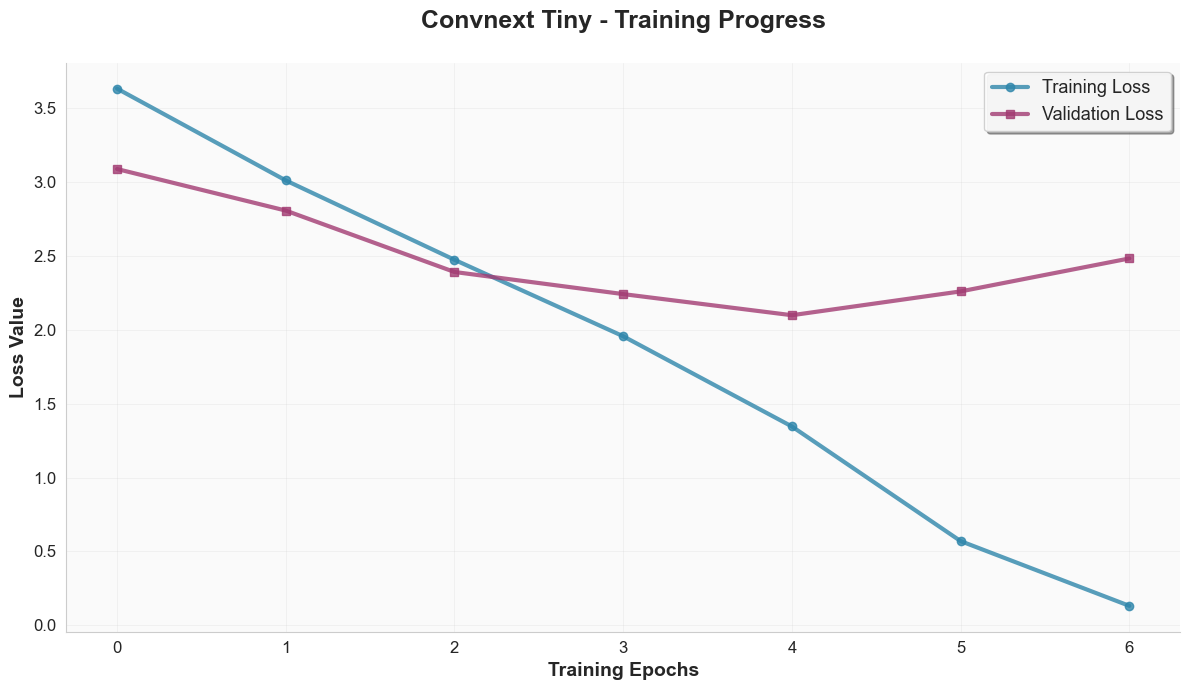

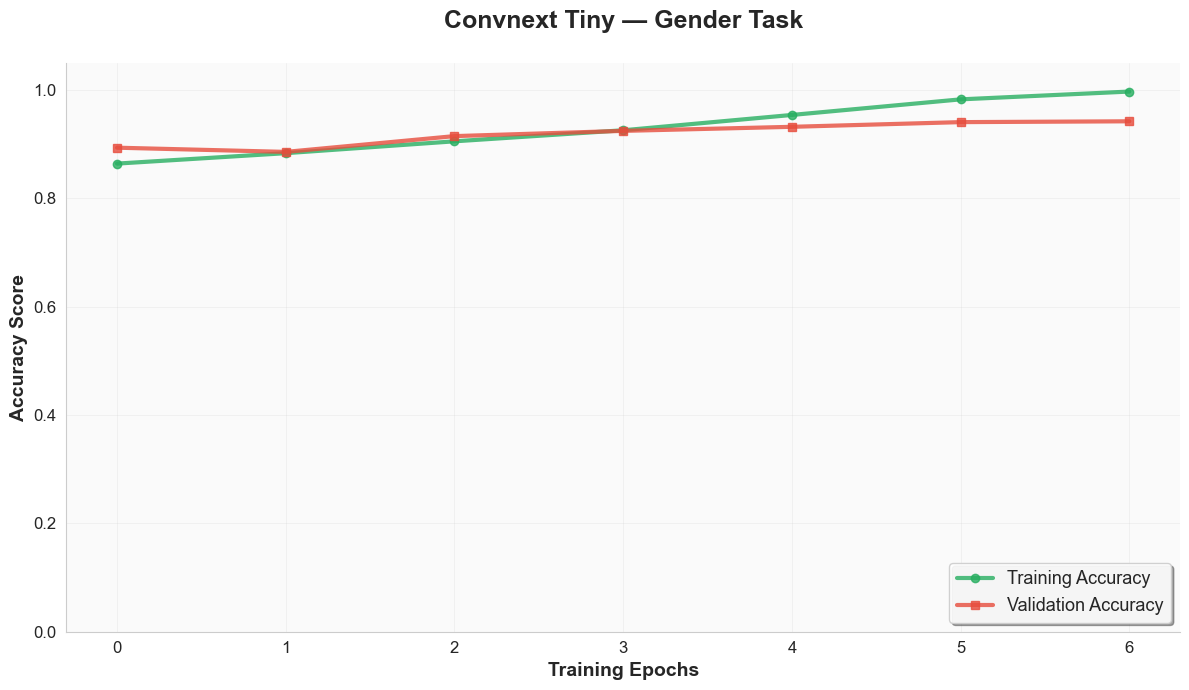

📊 Creating main comparison chart...


C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


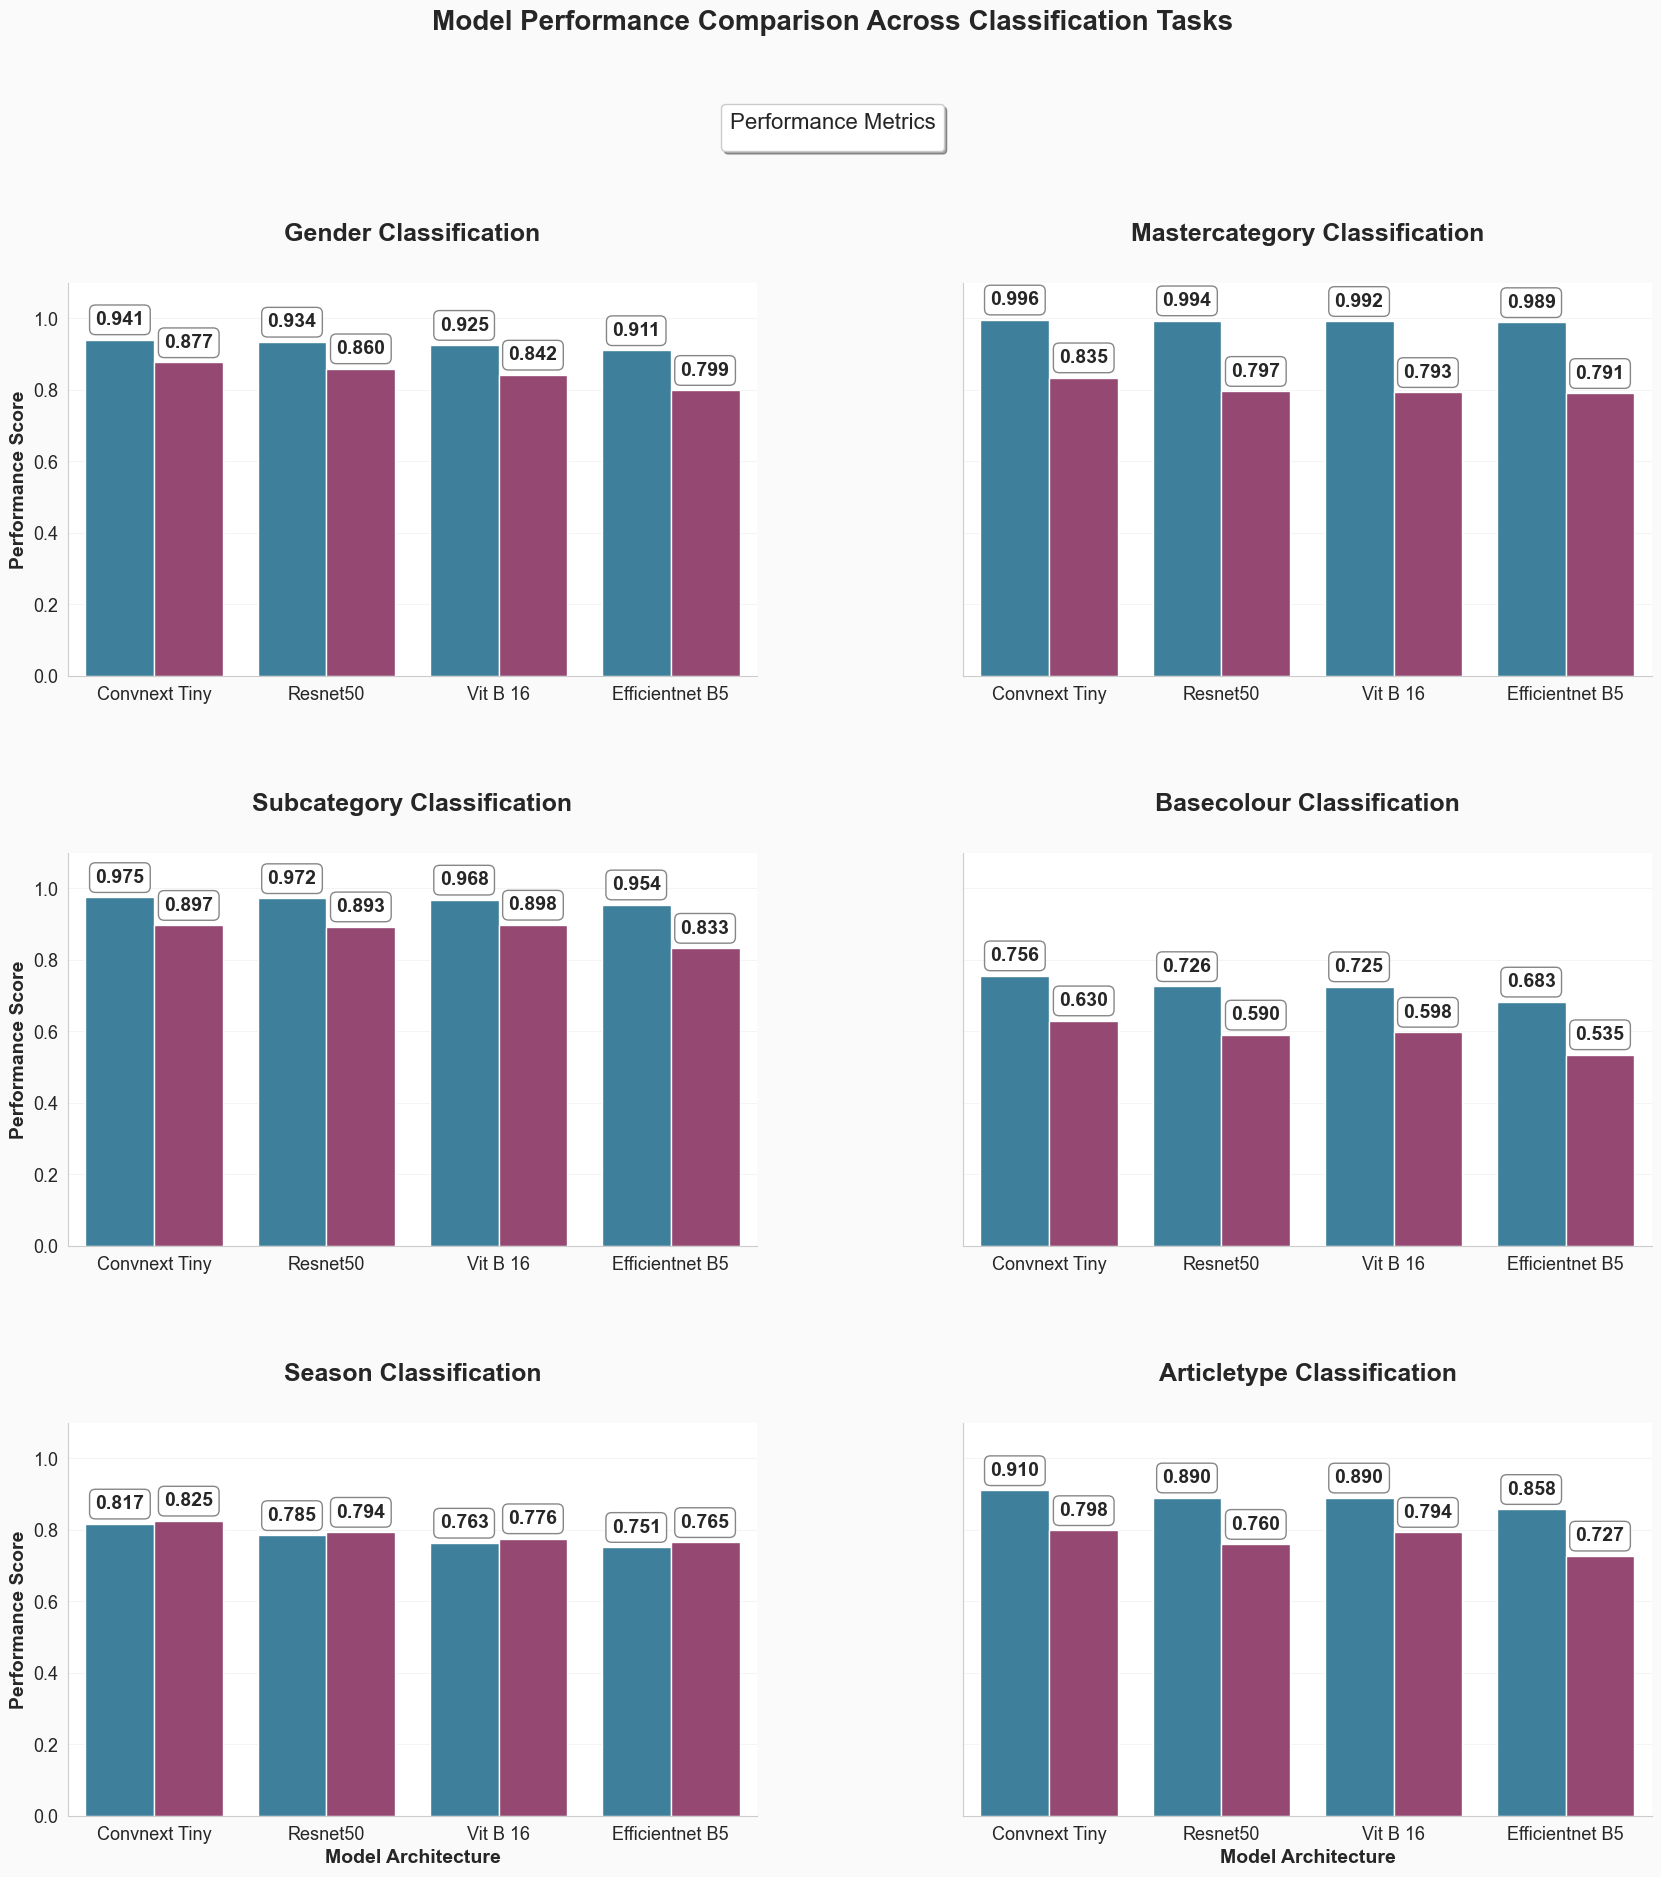

📋 Creating performance summary...


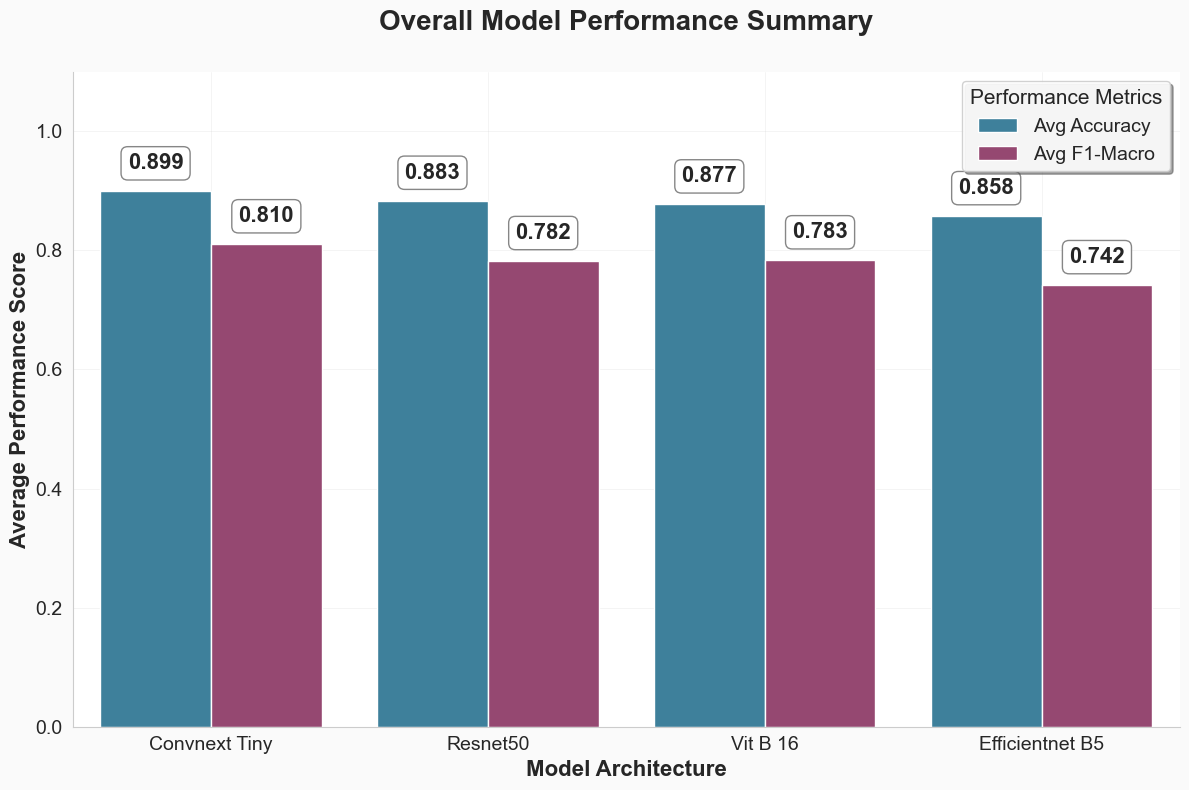

📝 Generating results table...

                      MODEL PERFORMANCE COMPARISON RESULTS                      

ACCURACY SCORES
--------------------------------------------------
Task            Articletype Basecolour  Gender Mastercategory  Season Subcategory
Model                                                                            
Convnext Tiny        0.9103     0.7561  0.9410         0.9963  0.8169      0.9751
Efficientnet B5      0.8577     0.6826  0.9105         0.9890  0.7515      0.9545
Resnet50             0.8899     0.7259  0.9343         0.9941  0.7847      0.9721
Vit B 16             0.8897     0.7254  0.9254         0.9922  0.7634      0.9680

F1-MACRO SCORES
--------------------------------------------------
Task            Articletype Basecolour  Gender Mastercategory  Season Subcategory
Model                                                                            
Convnext Tiny        0.7985     0.6300  0.8768         0.8346  0.8251      0.8972
Efficientnet B

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def compare_models(num_classes_dict, train_loader, val_loader, test_loader,
                   device, criterions, label_cols,
                   epochs=4, learning_rate=0.001):
    """
    Compare multiple models on the same dataset
    """
    models_to_test = ['convnext_tiny','resnet50','vit_b_16','efficientnet_b5']
    results = []

    for model_name in models_to_test:
        try:
            result = train_and_evaluate_model(
                model_name,
                num_classes_dict,
                train_loader,
                val_loader,
                test_loader,
                device,
                criterions,
                label_cols,
                epochs,
                learning_rate
            )
            results.append(result)
        except Exception as e:
            print(f"[!] Skipping {model_name}: {e}")
            continue

    return results


def plot_model_comparison_seaborn(results, label_cols):
    """
    Enhanced presentation-ready model comparison visualization with better spacing
    """
    # Build tidy DataFrame
    rows = []
    for res in results:
        model = res['model_name'].replace('_', ' ').title()
        for task in label_cols:
            rows.append({
                'Task': task.replace('_', ' ').title(),
                'Model': model,
                'Metric': 'Accuracy',
                'Score': res['test_metrics'][task]['accuracy']
            })
            rows.append({
                'Task': task.replace('_', ' ').title(),
                'Model': model,
                'Metric': 'F1-Macro',
                'Score': res['test_metrics'][task]['f1_macro']
            })
    df = pd.DataFrame(rows)

    # Enhanced styling & palette for presentations
    plt.style.use('default')
    sns.set_style('whitegrid')
    palette = {
        'Accuracy': '#2E86AB',     # Professional blue
        'F1-Macro': '#A23B72'      # Distinguished purple
    }

    # Create facet grid with better spacing - FIXED DIMENSIONS
    g = sns.catplot(
        data=df,
        x='Model', y='Score', hue='Metric', col='Task',
        kind='bar', palette=palette,
        height=7, aspect=1.3, sharey=True,  # Increased height and aspect ratio
        col_wrap=2,  # Only 2 plots per row for better spacing
        legend_out=False
    )

    # FIXED: Enhanced main title with much better positioning
    g.fig.suptitle('Model Performance Comparison Across Classification Tasks',
                   fontsize=20, fontweight='bold', y=0.98)  # Moved higher

    # Enhance each subplot for presentation quality
    for i, ax in enumerate(g.axes.flatten()):
        if i < len(label_cols):
            # Set y-axis with proper headroom
            ax.set_ylim(0, 1.1)  # More space for annotations
            
            # Enhanced axis labels
            ax.set_xlabel('Model Architecture', fontweight='bold', fontsize=14)
            ax.set_ylabel('Performance Score', fontweight='bold', fontsize=14)
            
            # Larger, more readable tick labels
            ax.tick_params(axis='x', rotation=0, labelsize=13)
            ax.tick_params(axis='y', labelsize=13)

            # FIXED: Much larger and more visible value annotations
            for p in ax.patches:
                h = p.get_height()
                if h > 0:  # Only annotate non-zero bars
                    ax.text(
                        p.get_x() + p.get_width()/2, h + 0.03,  # Higher position
                        f'{h:.3f}',
                        ha='center', va='bottom',
                        fontweight='bold', fontsize=14,  # LARGER FONT
                        bbox=dict(boxstyle="round,pad=0.3", 
                                facecolor='white', 
                                edgecolor='gray',
                                alpha=0.95)
                    )

            # FIXED: Enhanced subplot titles with more padding
            title = ax.get_title()
            if '=' in title:
                task_name = title.split('=')[1].strip()
                ax.set_title(f'{task_name} Classification', 
                           fontweight='bold', fontsize=18, pad=30)  # More padding

            # Professional grid styling
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
            ax.set_axisbelow(True)
            sns.despine(ax=ax)

    # Force x-axis labels to show on all subplots
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelbottom=True)
        ax.set_xlabel('Model Architecture', fontweight='bold', fontsize=14)
        unique_models = df['Model'].unique()
        ax.set_xticks(range(len(unique_models)))
        ax.set_xticklabels(unique_models, rotation=0, ha='center', fontsize=13)

    # FIXED: Enhanced legend positioning - moved much higher
    handles, labels = g.axes[0].get_legend_handles_labels()
    g.fig.legend(handles, labels, 
                loc='upper center', 
                bbox_to_anchor=(0.5, 0.94),  # Higher position
                ncol=2, 
                fontsize=15,
                frameon=True,
                fancybox=True,
                shadow=True,
                title='Performance Metrics',
                title_fontsize=16)

    # Remove individual subplot legends
    for ax in g.axes.flatten():
        legend = ax.get_legend()
        if legend:
            legend.remove()

    # FIXED: Better layout with more spacing
    g.fig.subplots_adjust(top=0.85, bottom=0.12, left=0.08, right=0.95,
                          wspace=0.3, hspace=0.45)  # More spacing
    
    # Professional background
    g.fig.patch.set_facecolor('#FAFAFA')

    plt.show()
    return g.fig


def plot_overall_performance_summary(results, label_cols):
    """
    FIXED: Simple bar chart only - removed radar chart to avoid overlap
    """
    # Build DataFrame for summary metrics
    rows = []
    for res in results:
        model = res['model_name'].replace('_', ' ').title()
        avg_acc = np.mean([res['test_metrics'][t]['accuracy'] for t in label_cols])
        avg_f1 = np.mean([res['test_metrics'][t]['f1_macro'] for t in label_cols])
        rows.append({'Model': model, 'Metric': 'Avg Accuracy', 'Score': avg_acc})
        rows.append({'Model': model, 'Metric': 'Avg F1-Macro', 'Score': avg_f1})
    df = pd.DataFrame(rows)

    # FIXED: Single plot layout - no more overlapping
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Enhanced styling
    sns.set_style('whitegrid')
    palette = {'Avg Accuracy': '#2E86AB', 'Avg F1-Macro': '#A23B72'}

    sns.barplot(data=df, x='Model', y='Score', hue='Metric',
                palette=palette, ax=ax)

    # Enhanced styling for presentations
    ax.set_ylim(0, 1.1)  # More space for annotations
    ax.set_ylabel('Average Performance Score', fontweight='bold', fontsize=16)
    ax.set_xlabel('Model Architecture', fontweight='bold', fontsize=16)
    ax.set_title('Overall Model Performance Summary',
                 fontsize=20, fontweight='bold', pad=30)
    ax.tick_params(axis='x', rotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # FIXED: Much larger bar annotations
    for bar in ax.patches:
        h = bar.get_height()
        if h > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2, h + 0.03,
                f'{h:.3f}',
                ha='center', va='bottom',
                fontweight='bold', fontsize=16,  # LARGER FONT
                bbox=dict(boxstyle="round,pad=0.3", 
                         facecolor='white', 
                         edgecolor='gray',
                         alpha=0.95)
            )

    # Enhanced legend
    legend = ax.legend(fontsize=14, loc='upper right', frameon=True,
                      fancybox=True, shadow=True, 
                      title='Performance Metrics', title_fontsize=15)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)

    # Professional grid styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    sns.despine(ax=ax)

    # Overall figure styling
    fig.patch.set_facecolor('#FAFAFA')
    
    plt.tight_layout()
    plt.show()
    return fig


def plot_simple_loss_curve(results, model_index=0):
    """
    Enhanced loss curve visualization
    """
    if not results or model_index >= len(results):
        return

    res = results[model_index]

    # Enhanced figure size and styling
    fig, ax = plt.subplots(figsize=(12, 7))

    # Professional styling with enhanced markers
    ax.plot(res['train_losses'], label='Training Loss', linewidth=3,
            color='#2E86AB', marker='o', markersize=6, alpha=0.8)
    ax.plot(res['val_losses'], label='Validation Loss', linewidth=3,
            color='#A23B72', marker='s', markersize=6, alpha=0.8)

    # Enhanced labels and title
    ax.set_xlabel('Training Epochs', fontweight='bold', fontsize=14)
    ax.set_ylabel('Loss Value', fontweight='bold', fontsize=14)
    ax.set_title(f'{res["model_name"].replace("_", " ").title()} - Training Progress',
                 fontweight='bold', fontsize=18, pad=25)

    # Enhanced legend
    legend = ax.legend(fontsize=13, loc='upper right', frameon=True,
                      fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Professional grid and styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_facecolor('#FAFAFA')

    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    return fig


def plot_simple_accuracy_curve(results, model_index=0, task_index=0, label_cols=None):
    """
    Enhanced accuracy curve visualization
    """
    if not results or not label_cols or model_index >= len(results) or task_index >= len(label_cols):
        return

    res = results[model_index]
    task = label_cols[task_index]

    # Enhanced figure
    fig, ax = plt.subplots(figsize=(12, 7))

    train_acc = [m[task]['accuracy'] for m in res['train_metrics']]
    val_acc = [m[task]['accuracy'] for m in res['val_metrics']]

    # Enhanced plotting with professional styling
    ax.plot(train_acc, label='Training Accuracy', linewidth=3,
            color='#27AE60', marker='o', markersize=6, alpha=0.8)
    ax.plot(val_acc, label='Validation Accuracy', linewidth=3,
            color='#E74C3C', marker='s', markersize=6, alpha=0.8)

    # Enhanced labels
    ax.set_xlabel('Training Epochs', fontweight='bold', fontsize=14)
    ax.set_ylabel('Accuracy Score', fontweight='bold', fontsize=14)
    ax.set_title(f"{res['model_name'].replace('_', ' ').title()} — {task.replace('_', ' ').title()} Task",
                 fontweight='bold', fontsize=18, pad=25)

    ax.set_ylim(0, 1.05)
    
    # Enhanced legend
    legend = ax.legend(fontsize=13, loc='lower right', frameon=True,
                      fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Professional styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_facecolor('#FAFAFA')

    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    return fig


def create_summary_table(results, label_cols):
    """
    Enhanced presentation-ready summary table without combined score
    """
    if not results:
        return

    # Build detailed results table
    rows = []
    for res in results:
        model = res['model_name'].replace('_', ' ').title()
        for t in label_cols:
            rows.append({
                'Model': model,
                'Task': t.replace('_', ' ').title(),
                'Accuracy': f"{res['test_metrics'][t]['accuracy']:.4f}",
                'F1-Macro': f"{res['test_metrics'][t]['f1_macro']:.4f}"
            })

    df = pd.DataFrame(rows)
    acc_tab = df.pivot(index='Model', columns='Task', values='Accuracy')
    f1_tab = df.pivot(index='Model', columns='Task', values='F1-Macro')

    # Enhanced table presentation
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON RESULTS".center(80))
    print("="*80)
    print("\nACCURACY SCORES")
    print("-" * 50)
    print(acc_tab.to_string())
    print("\nF1-MACRO SCORES")
    print("-" * 50)
    print(f1_tab.to_string())

    # Calculate and display averages (NO MORE COMBINED SCORE)
    avg_results = []
    for res in results:
        model = res['model_name'].replace('_', ' ').title()
        avg_acc = np.mean([res['test_metrics'][t]['accuracy'] for t in label_cols])
        avg_f1 = np.mean([res['test_metrics'][t]['f1_macro'] for t in label_cols])
        avg_results.append({
            'Model': model,
            'Avg Accuracy': avg_acc,
            'Avg F1-Macro': avg_f1
        })

    avg_df = pd.DataFrame(avg_results).set_index('Model')
    avg_df = avg_df.sort_values('Avg Accuracy', ascending=False)  # Rank by accuracy

    print("\n" + "="*80)
    print("OVERALL PERFORMANCE RANKING".center(80))
    print("="*80)
    print(avg_df.round(4).to_string())
    print("="*80)
    print(f"\n🏆 Best Accuracy Model: {avg_df.index[0]} (Accuracy: {avg_df.iloc[0]['Avg Accuracy']:.4f})")
    
    # Find best F1 model
    best_f1_model = avg_df.sort_values('Avg F1-Macro', ascending=False).index[0]
    best_f1_score = avg_df.loc[best_f1_model, 'Avg F1-Macro']
    print(f"🏆 Best F1-Macro Model: {best_f1_model} (F1-Macro: {best_f1_score:.4f})")
    print("="*80)

    return acc_tab, f1_tab, avg_df


# -----------------------------------------------------------------------------
# MAIN EXECUTION SECTION - Single training workflow
# -----------------------------------------------------------------------------
def run_complete_model_analysis(num_classes_dict, train_loader, val_loader, test_loader,
                               device, criterions, label_cols, epochs=5, learning_rate=0.001):
    """
    Complete enhanced model comparison workflow - trains models ONCE and generates all visualizations
    """
    print("🚀 Starting Enhanced Model Comparison Analysis...")
    print("="*80)
    
    # Run model comparison ONCE
    results = compare_models(
        num_classes_dict=num_classes_dict,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        criterions=criterions,
        label_cols=label_cols,
        epochs=epochs,
        learning_rate=learning_rate
    )
    
    if not results:
        print("❌ No results to analyze. Check your model training.")
        return None
    
    print(f"✅ Successfully trained and evaluated {len(results)} models")
    print("="*80)
    
    # Generate all visualizations using the SAME results
    print("📊 Generating visualizations...")
    
    # 1. Training curves for FIRST model only (as requested)
    print("📈 Creating training curves for first model...")
    fig_loss = plot_simple_loss_curve(results, model_index=0)
    
    # Create accuracy curve for first task of first model
    fig_acc = plot_simple_accuracy_curve(results, model_index=0, 
                                       task_index=0, label_cols=label_cols)
    
    # 2. Main comparison visualization
    print("📊 Creating main comparison chart...")
    fig_comparison = plot_model_comparison_seaborn(results, label_cols)
    
    # 3. Overall performance summary (NO MORE RADAR CHART)
    print("📋 Creating performance summary...")
    fig_summary = plot_overall_performance_summary(results, label_cols)
    
    # 4. Detailed results table
    print("📝 Generating results table...")
    acc_table, f1_table, avg_table = create_summary_table(results, label_cols)
    
    print("✅ Analysis complete! All visualizations and tables generated.")
    print("="*80)
    
    return {
        'results': results,
        'figures': {
            'comparison': fig_comparison,
            'summary': fig_summary,
            'loss_curve': fig_loss,
            'accuracy_curve': fig_acc
        },
        'tables': {
            'accuracy': acc_table,
            'f1_macro': f1_table,
            'averages': avg_table
        }
    }


# -----------------------------------------------------------------------------
# USAGE - RECOMMENDED APPROACH (Train Once, Visualize Multiple Ways)
# -----------------------------------------------------------------------------

# RECOMMENDED: Use the complete workflow (trains models once)
analysis_results = run_complete_model_analysis(
    num_classes_dict=num_classes_dict,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    criterions=criterions,
    label_cols=label_cols,
    epochs=7,
    learning_rate=0.001
)

In [36]:
# Train the model using the provided function
result = train_and_evaluate_model(
    "convnext_tiny",
    num_classes_dict,
    train_loader,
    val_loader,
    test_loader,
    device,
    criterions,
    label_cols,
    epochs=20,  # Added parameter name for clarity
    learning_rate=0.0001
)


Training model: CONVNEXT_TINY
Model: convnext_tiny
Total params: 27,935,478 | Trainable: 26,698,902 (95.57%)
GPU Mem (allocated): 0.60 GB
GPU Mem (reserved) : 1.19 GB


100%|██████████| 492/492 [05:17<00:00,  1.55it/s]



Epoch 1/20 | Train Loss: 5.1501 | Val Loss: 3.0633
gender         | Train Acc: 0.8325 | Val Acc: 0.8927 | Train F1: 0.5980 | Val F1: 0.6411
masterCategory | Train Acc: 0.9619 | Val Acc: 0.9920 | Train F1: 0.7594 | Val F1: 0.7934
subCategory    | Train Acc: 0.8514 | Val Acc: 0.9477 | Train F1: 0.5442 | Val F1: 0.7300
baseColour     | Train Acc: 0.5065 | Val Acc: 0.6757 | Train F1: 0.2675 | Val F1: 0.4163
season         | Train Acc: 0.6558 | Val Acc: 0.6882 | Train F1: 0.6557 | Val F1: 0.6890
articleType    | Train Acc: 0.6569 | Val Acc: 0.8019 | Train F1: 0.2853 | Val F1: 0.4163


100%|██████████| 492/492 [05:19<00:00,  1.54it/s]



Epoch 2/20 | Train Loss: 2.6089 | Val Loss: 2.4322
gender         | Train Acc: 0.9051 | Val Acc: 0.9125 | Train F1: 0.7257 | Val F1: 0.7653
masterCategory | Train Acc: 0.9943 | Val Acc: 0.9952 | Train F1: 0.7960 | Val F1: 0.7974
subCategory    | Train Acc: 0.9594 | Val Acc: 0.9621 | Train F1: 0.8141 | Val F1: 0.8435
baseColour     | Train Acc: 0.7128 | Val Acc: 0.7245 | Train F1: 0.4949 | Val F1: 0.5058
season         | Train Acc: 0.7125 | Val Acc: 0.7201 | Train F1: 0.7309 | Val F1: 0.7286
articleType    | Train Acc: 0.8446 | Val Acc: 0.8561 | Train F1: 0.5599 | Val F1: 0.6206


100%|██████████| 492/492 [05:14<00:00,  1.57it/s]



Epoch 3/20 | Train Loss: 2.1485 | Val Loss: 2.2831
gender         | Train Acc: 0.9214 | Val Acc: 0.9138 | Train F1: 0.7795 | Val F1: 0.7731
masterCategory | Train Acc: 0.9956 | Val Acc: 0.9940 | Train F1: 0.8074 | Val F1: 0.7938
subCategory    | Train Acc: 0.9714 | Val Acc: 0.9624 | Train F1: 0.8763 | Val F1: 0.8560
baseColour     | Train Acc: 0.7476 | Val Acc: 0.7237 | Train F1: 0.5716 | Val F1: 0.5167
season         | Train Acc: 0.7442 | Val Acc: 0.7607 | Train F1: 0.7587 | Val F1: 0.7694
articleType    | Train Acc: 0.8805 | Val Acc: 0.8738 | Train F1: 0.6931 | Val F1: 0.6627


100%|██████████| 492/492 [05:26<00:00,  1.51it/s]



Epoch 4/20 | Train Loss: 1.8179 | Val Loss: 2.3196
gender         | Train Acc: 0.9362 | Val Acc: 0.9148 | Train F1: 0.8215 | Val F1: 0.7957
masterCategory | Train Acc: 0.9959 | Val Acc: 0.9939 | Train F1: 0.8114 | Val F1: 0.7957
subCategory    | Train Acc: 0.9776 | Val Acc: 0.9677 | Train F1: 0.9056 | Val F1: 0.8570
baseColour     | Train Acc: 0.7750 | Val Acc: 0.7143 | Train F1: 0.6249 | Val F1: 0.5432
season         | Train Acc: 0.7784 | Val Acc: 0.7667 | Train F1: 0.7881 | Val F1: 0.7750
articleType    | Train Acc: 0.9020 | Val Acc: 0.8762 | Train F1: 0.7809 | Val F1: 0.7092


100%|██████████| 492/492 [05:28<00:00,  1.50it/s]



Epoch 5/20 | Train Loss: 1.5688 | Val Loss: 2.2336
gender         | Train Acc: 0.9461 | Val Acc: 0.9245 | Train F1: 0.8489 | Val F1: 0.8037
masterCategory | Train Acc: 0.9956 | Val Acc: 0.9936 | Train F1: 0.8560 | Val F1: 0.8131
subCategory    | Train Acc: 0.9818 | Val Acc: 0.9664 | Train F1: 0.9178 | Val F1: 0.8604
baseColour     | Train Acc: 0.8043 | Val Acc: 0.7323 | Train F1: 0.6737 | Val F1: 0.5478
season         | Train Acc: 0.8102 | Val Acc: 0.7811 | Train F1: 0.8155 | Val F1: 0.7922
articleType    | Train Acc: 0.9207 | Val Acc: 0.8782 | Train F1: 0.8302 | Val F1: 0.7145


100%|██████████| 492/492 [05:46<00:00,  1.42it/s]



Epoch 6/20 | Train Loss: 1.2531 | Val Loss: 2.2484
gender         | Train Acc: 0.9558 | Val Acc: 0.9221 | Train F1: 0.8787 | Val F1: 0.7981
masterCategory | Train Acc: 0.9966 | Val Acc: 0.9943 | Train F1: 0.8704 | Val F1: 0.8156
subCategory    | Train Acc: 0.9863 | Val Acc: 0.9713 | Train F1: 0.9374 | Val F1: 0.8834
baseColour     | Train Acc: 0.8428 | Val Acc: 0.7304 | Train F1: 0.7427 | Val F1: 0.5697
season         | Train Acc: 0.8491 | Val Acc: 0.7874 | Train F1: 0.8492 | Val F1: 0.7942
articleType    | Train Acc: 0.9373 | Val Acc: 0.8930 | Train F1: 0.8661 | Val F1: 0.7566


100%|██████████| 492/492 [05:36<00:00,  1.46it/s]



Epoch 7/20 | Train Loss: 0.9038 | Val Loss: 2.3822
gender         | Train Acc: 0.9678 | Val Acc: 0.9266 | Train F1: 0.9094 | Val F1: 0.8112
masterCategory | Train Acc: 0.9973 | Val Acc: 0.9945 | Train F1: 0.9070 | Val F1: 0.8131
subCategory    | Train Acc: 0.9907 | Val Acc: 0.9680 | Train F1: 0.9569 | Val F1: 0.8640
baseColour     | Train Acc: 0.8834 | Val Acc: 0.7390 | Train F1: 0.8063 | Val F1: 0.5896
season         | Train Acc: 0.8898 | Val Acc: 0.7909 | Train F1: 0.8875 | Val F1: 0.8041
articleType    | Train Acc: 0.9576 | Val Acc: 0.8876 | Train F1: 0.9200 | Val F1: 0.7446


100%|██████████| 492/492 [05:17<00:00,  1.55it/s]



Epoch 8/20 | Train Loss: 0.6552 | Val Loss: 2.4919
gender         | Train Acc: 0.9781 | Val Acc: 0.9333 | Train F1: 0.9461 | Val F1: 0.8430
masterCategory | Train Acc: 0.9974 | Val Acc: 0.9945 | Train F1: 0.9303 | Val F1: 0.8465
subCategory    | Train Acc: 0.9926 | Val Acc: 0.9746 | Train F1: 0.9653 | Val F1: 0.8862
baseColour     | Train Acc: 0.9160 | Val Acc: 0.7419 | Train F1: 0.8614 | Val F1: 0.5902
season         | Train Acc: 0.9228 | Val Acc: 0.7904 | Train F1: 0.9194 | Val F1: 0.7973
articleType    | Train Acc: 0.9695 | Val Acc: 0.8960 | Train F1: 0.9357 | Val F1: 0.7774


100%|██████████| 492/492 [05:14<00:00,  1.57it/s]



Epoch 9/20 | Train Loss: 0.4401 | Val Loss: 2.6704
gender         | Train Acc: 0.9850 | Val Acc: 0.9355 | Train F1: 0.9625 | Val F1: 0.8414
masterCategory | Train Acc: 0.9987 | Val Acc: 0.9936 | Train F1: 0.9633 | Val F1: 0.8703
subCategory    | Train Acc: 0.9952 | Val Acc: 0.9730 | Train F1: 0.9806 | Val F1: 0.8974
baseColour     | Train Acc: 0.9428 | Val Acc: 0.7370 | Train F1: 0.9080 | Val F1: 0.6085
season         | Train Acc: 0.9513 | Val Acc: 0.7954 | Train F1: 0.9483 | Val F1: 0.7996
articleType    | Train Acc: 0.9806 | Val Acc: 0.8927 | Train F1: 0.9651 | Val F1: 0.8019


100%|██████████| 492/492 [05:16<00:00,  1.56it/s]



Epoch 10/20 | Train Loss: 0.2899 | Val Loss: 2.8172
gender         | Train Acc: 0.9901 | Val Acc: 0.9357 | Train F1: 0.9782 | Val F1: 0.8439
masterCategory | Train Acc: 0.9984 | Val Acc: 0.9953 | Train F1: 0.9698 | Val F1: 0.8311
subCategory    | Train Acc: 0.9967 | Val Acc: 0.9751 | Train F1: 0.9883 | Val F1: 0.8960
baseColour     | Train Acc: 0.9634 | Val Acc: 0.7502 | Train F1: 0.9387 | Val F1: 0.5881
season         | Train Acc: 0.9714 | Val Acc: 0.8038 | Train F1: 0.9707 | Val F1: 0.8048
articleType    | Train Acc: 0.9876 | Val Acc: 0.9044 | Train F1: 0.9738 | Val F1: 0.8062


100%|██████████| 492/492 [05:16<00:00,  1.55it/s]



Epoch 11/20 | Train Loss: 0.1876 | Val Loss: 3.0697
gender         | Train Acc: 0.9939 | Val Acc: 0.9385 | Train F1: 0.9844 | Val F1: 0.8478
masterCategory | Train Acc: 0.9989 | Val Acc: 0.9952 | Train F1: 0.9768 | Val F1: 0.8532
subCategory    | Train Acc: 0.9981 | Val Acc: 0.9736 | Train F1: 0.9900 | Val F1: 0.8894
baseColour     | Train Acc: 0.9758 | Val Acc: 0.7466 | Train F1: 0.9576 | Val F1: 0.5918
season         | Train Acc: 0.9807 | Val Acc: 0.7972 | Train F1: 0.9797 | Val F1: 0.7982
articleType    | Train Acc: 0.9935 | Val Acc: 0.9034 | Train F1: 0.9876 | Val F1: 0.7936


100%|██████████| 492/492 [05:14<00:00,  1.57it/s]



Epoch 12/20 | Train Loss: 0.1241 | Val Loss: 3.1559
gender         | Train Acc: 0.9957 | Val Acc: 0.9386 | Train F1: 0.9897 | Val F1: 0.8528
masterCategory | Train Acc: 0.9993 | Val Acc: 0.9952 | Train F1: 0.9832 | Val F1: 0.8490
subCategory    | Train Acc: 0.9984 | Val Acc: 0.9765 | Train F1: 0.9872 | Val F1: 0.8967
baseColour     | Train Acc: 0.9841 | Val Acc: 0.7456 | Train F1: 0.9733 | Val F1: 0.5892
season         | Train Acc: 0.9901 | Val Acc: 0.8127 | Train F1: 0.9898 | Val F1: 0.8133
articleType    | Train Acc: 0.9962 | Val Acc: 0.9061 | Train F1: 0.9919 | Val F1: 0.8070


100%|██████████| 492/492 [05:13<00:00,  1.57it/s]



Epoch 13/20 | Train Loss: 0.0716 | Val Loss: 3.2353
gender         | Train Acc: 0.9977 | Val Acc: 0.9424 | Train F1: 0.9938 | Val F1: 0.8637
masterCategory | Train Acc: 0.9995 | Val Acc: 0.9961 | Train F1: 0.9848 | Val F1: 0.8643
subCategory    | Train Acc: 0.9991 | Val Acc: 0.9767 | Train F1: 0.9933 | Val F1: 0.8966
baseColour     | Train Acc: 0.9907 | Val Acc: 0.7586 | Train F1: 0.9835 | Val F1: 0.6192
season         | Train Acc: 0.9949 | Val Acc: 0.8176 | Train F1: 0.9954 | Val F1: 0.8217
articleType    | Train Acc: 0.9978 | Val Acc: 0.9015 | Train F1: 0.9953 | Val F1: 0.7999


100%|██████████| 492/492 [05:27<00:00,  1.50it/s]



Epoch 14/20 | Train Loss: 0.0384 | Val Loss: 3.2986
gender         | Train Acc: 0.9993 | Val Acc: 0.9448 | Train F1: 0.9987 | Val F1: 0.8648
masterCategory | Train Acc: 0.9996 | Val Acc: 0.9959 | Train F1: 0.9943 | Val F1: 0.8342
subCategory    | Train Acc: 0.9995 | Val Acc: 0.9757 | Train F1: 0.9982 | Val F1: 0.8931
baseColour     | Train Acc: 0.9941 | Val Acc: 0.7657 | Train F1: 0.9903 | Val F1: 0.6242
season         | Train Acc: 0.9978 | Val Acc: 0.8202 | Train F1: 0.9976 | Val F1: 0.8240
articleType    | Train Acc: 0.9992 | Val Acc: 0.9087 | Train F1: 0.9978 | Val F1: 0.8045


100%|██████████| 492/492 [05:13<00:00,  1.57it/s]



Epoch 15/20 | Train Loss: 0.0223 | Val Loss: 3.3408
gender         | Train Acc: 0.9997 | Val Acc: 0.9461 | Train F1: 0.9990 | Val F1: 0.8671
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9956 | Train F1: 0.9945 | Val F1: 0.8337
subCategory    | Train Acc: 0.9996 | Val Acc: 0.9771 | Train F1: 0.9983 | Val F1: 0.8933
baseColour     | Train Acc: 0.9959 | Val Acc: 0.7688 | Train F1: 0.9927 | Val F1: 0.6267
season         | Train Acc: 0.9993 | Val Acc: 0.8223 | Train F1: 0.9990 | Val F1: 0.8262
articleType    | Train Acc: 0.9994 | Val Acc: 0.9102 | Train F1: 0.9986 | Val F1: 0.7992


100%|██████████| 492/492 [05:22<00:00,  1.53it/s]



Epoch 16/20 | Train Loss: 0.0147 | Val Loss: 3.4004
gender         | Train Acc: 0.9997 | Val Acc: 0.9471 | Train F1: 0.9987 | Val F1: 0.8687
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9957 | Train F1: 0.9958 | Val F1: 0.8340
subCategory    | Train Acc: 0.9997 | Val Acc: 0.9767 | Train F1: 0.9991 | Val F1: 0.9020
baseColour     | Train Acc: 0.9965 | Val Acc: 0.7724 | Train F1: 0.9937 | Val F1: 0.6324
season         | Train Acc: 0.9992 | Val Acc: 0.8247 | Train F1: 0.9988 | Val F1: 0.8276
articleType    | Train Acc: 0.9996 | Val Acc: 0.9102 | Train F1: 0.9995 | Val F1: 0.8073


100%|██████████| 492/492 [05:15<00:00,  1.56it/s]



Epoch 17/20 | Train Loss: 0.0105 | Val Loss: 3.4337
gender         | Train Acc: 0.9998 | Val Acc: 0.9483 | Train F1: 0.9993 | Val F1: 0.8708
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9958 | Train F1: 0.9932 | Val F1: 0.8341
subCategory    | Train Acc: 0.9997 | Val Acc: 0.9769 | Train F1: 0.9986 | Val F1: 0.8992
baseColour     | Train Acc: 0.9972 | Val Acc: 0.7710 | Train F1: 0.9950 | Val F1: 0.6304
season         | Train Acc: 0.9996 | Val Acc: 0.8266 | Train F1: 0.9993 | Val F1: 0.8296
articleType    | Train Acc: 0.9996 | Val Acc: 0.9106 | Train F1: 0.9994 | Val F1: 0.8111


100%|██████████| 492/492 [05:18<00:00,  1.55it/s]



Epoch 18/20 | Train Loss: 0.0077 | Val Loss: 3.4737
gender         | Train Acc: 0.9997 | Val Acc: 0.9479 | Train F1: 0.9991 | Val F1: 0.8714
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9958 | Train F1: 0.9945 | Val F1: 0.8341
subCategory    | Train Acc: 0.9997 | Val Acc: 0.9770 | Train F1: 0.9988 | Val F1: 0.8988
baseColour     | Train Acc: 0.9977 | Val Acc: 0.7746 | Train F1: 0.9963 | Val F1: 0.6342
season         | Train Acc: 0.9997 | Val Acc: 0.8249 | Train F1: 0.9995 | Val F1: 0.8277
articleType    | Train Acc: 0.9997 | Val Acc: 0.9110 | Train F1: 0.9995 | Val F1: 0.8105


100%|██████████| 492/492 [05:13<00:00,  1.57it/s]



Epoch 19/20 | Train Loss: 0.0061 | Val Loss: 3.4955
gender         | Train Acc: 0.9998 | Val Acc: 0.9476 | Train F1: 0.9991 | Val F1: 0.8690
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9958 | Train F1: 0.9945 | Val F1: 0.8341
subCategory    | Train Acc: 0.9998 | Val Acc: 0.9770 | Train F1: 0.9988 | Val F1: 0.9005
baseColour     | Train Acc: 0.9983 | Val Acc: 0.7726 | Train F1: 0.9971 | Val F1: 0.6324
season         | Train Acc: 0.9997 | Val Acc: 0.8251 | Train F1: 0.9996 | Val F1: 0.8281
articleType    | Train Acc: 0.9997 | Val Acc: 0.9118 | Train F1: 0.9995 | Val F1: 0.8122


100%|██████████| 492/492 [05:15<00:00,  1.56it/s]



Epoch 20/20 | Train Loss: 0.0053 | Val Loss: 3.4996
gender         | Train Acc: 0.9998 | Val Acc: 0.9477 | Train F1: 0.9994 | Val F1: 0.8690
masterCategory | Train Acc: 0.9998 | Val Acc: 0.9958 | Train F1: 0.9959 | Val F1: 0.8341
subCategory    | Train Acc: 0.9998 | Val Acc: 0.9770 | Train F1: 0.9991 | Val F1: 0.9005
baseColour     | Train Acc: 0.9987 | Val Acc: 0.7727 | Train F1: 0.9979 | Val F1: 0.6324
season         | Train Acc: 0.9998 | Val Acc: 0.8249 | Train F1: 0.9997 | Val F1: 0.8280
articleType    | Train Acc: 0.9997 | Val Acc: 0.9120 | Train F1: 0.9996 | Val F1: 0.8123

Final Test Set Evaluation for convnext_tiny
Test Loss: 3.4942
gender         | Accuracy: 0.9446 | Macro F1: 0.8721
masterCategory | Accuracy: 0.9957 | Macro F1: 0.8333
subCategory    | Accuracy: 0.9776 | Macro F1: 0.8926
baseColour     | Accuracy: 0.7677 | Macro F1: 0.6475
season         | Accuracy: 0.8311 | Macro F1: 0.8359
articleType    | Accuracy: 0.9144 | Macro F1: 0.8163


In [39]:

# Calculate average accuracy across all tasks
def calculate_average_accuracy(result):
    """
    Calculate average accuracy across all tasks from the training result.
    
    Args:
        result (dict): Result dictionary from train_and_evaluate_model function
    
    Returns:
        dict: Dictionary containing average accuracies for train, val, and test sets
    """
    # Get the final epoch metrics (last entry in the history)
    final_train_metrics = result['train_metrics'][-1]  # Last epoch
    final_val_metrics = result['val_metrics'][-1]      # Last epoch
    test_metrics = result['test_metrics']
    
    # Calculate average accuracy for training set (final epoch)
    train_accuracies = [final_train_metrics[task]['accuracy'] for task in final_train_metrics.keys()]
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    
    # Calculate average accuracy for validation set (final epoch)
    val_accuracies = [final_val_metrics[task]['accuracy'] for task in final_val_metrics.keys()]
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    
    # Calculate average accuracy for test set
    test_accuracies = [test_metrics[task]['accuracy'] for task in test_metrics.keys()]
    avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
    
    return {
        'avg_train_accuracy': avg_train_accuracy,
        'avg_val_accuracy': avg_val_accuracy,
        'avg_test_accuracy': avg_test_accuracy,
        'individual_test_accuracies': {task: test_metrics[task]['accuracy'] for task in test_metrics.keys()}
    }

# Calculate and display average accuracies
avg_accuracies = calculate_average_accuracy(result)

print("\n" + "=" * 60)
print("AVERAGE ACCURACY RESULTS")
print("=" * 60)

print(f"Average Test Accuracy: {avg_accuracies['avg_test_accuracy']:.4f}")

print("\nIndividual Test Accuracies by Task:")
print("-" * 40)
for task, accuracy in avg_accuracies['individual_test_accuracies'].items():
    print(f"{task:<20}: {accuracy:.4f}")

# Optional: Calculate average F1 scores as well
def calculate_average_f1(result):
    """Calculate average F1 scores across all tasks."""
    final_train_metrics = result['train_metrics'][-1]
    final_val_metrics = result['val_metrics'][-1]
    test_metrics = result['test_metrics']
    
    train_f1s = [final_train_metrics[task]['f1_macro'] for task in final_train_metrics.keys()]
    val_f1s = [final_val_metrics[task]['f1_macro'] for task in final_val_metrics.keys()]
    test_f1s = [test_metrics[task]['f1_macro'] for task in test_metrics.keys()]
    
    return {
        'avg_train_f1': sum(train_f1s) / len(train_f1s),
        'avg_val_f1': sum(val_f1s) / len(val_f1s),
        'avg_test_f1': sum(test_f1s) / len(test_f1s)
    }

avg_f1_scores = calculate_average_f1(result)
print("\nAverage F1 Scores:")
print("-" * 20)
print(f"Average Test F1: {avg_f1_scores['avg_test_f1']:.4f}")


AVERAGE ACCURACY RESULTS
Average Test Accuracy: 0.9052

Individual Test Accuracies by Task:
----------------------------------------
gender              : 0.9446
masterCategory      : 0.9957
subCategory         : 0.9776
baseColour          : 0.7677
season              : 0.8311
articleType         : 0.9144

Average F1 Scores:
--------------------
Average Test F1: 0.8163
